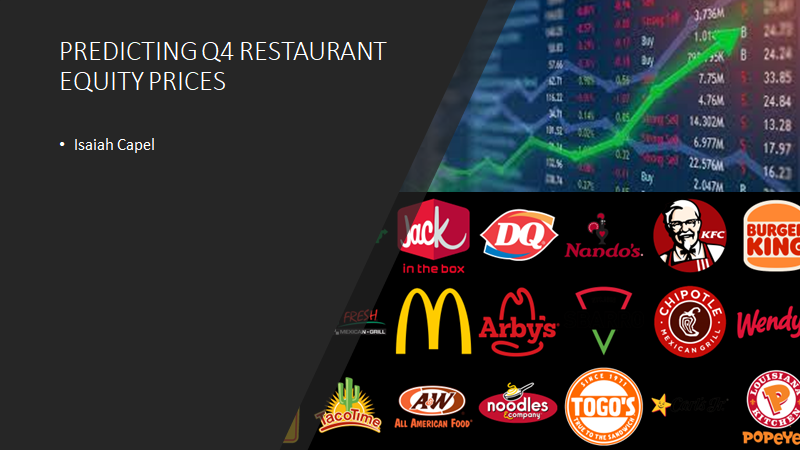

# SUMMARY

This notebook is intended for a hypothetical pension fund looking to cut out the hedge fund or private equity fees by looking to do their own trading. They have asked me to predict which of the top 14 American restaurant stocks will peform best and which will perform worst. 

Of course, examining the restaurant sector without also examining COIVD-19 numbers seems unwise since even 2.5 years in to COVID era, many of these businesses are still greatly depend on customers dining at their establishments. Therefore, I used data from the Center for Disease Control(CDC) to predict the COVID numbers for the rest of the year. Then, I made an LSTM model of closing prices for all 14 companies over the last 5 years with the exogenous variable of COVID deaths. Then, I made predicitons on that model using the COVID numbers that I predicted. I conlcuded that **Papa Johns, Cracker Barrel, and Dominos would perform best and Chipotle, Wingstop, and McDonalds will perfrom worst.**



# BUSINESS UNDERSTANDING

Currently, the market is in a period of uncertainty. Interest rate hikes, supply chain questions, international conflicts, and a still unrelenting but increasingly silent pandemic hover over the marketplace. For any investors looking to save on fees and do their own trading, these problems making profitable trading a daunting task. The restaurant industry, in particular, is vulnerable to so many of those issues. 

My task is to help navigate this perilous industry by providing you with the restaurant industry equities that will perform best in the remainder of this year and the equities that will perform worse. I am using closing price data from Yahoo Finance. Yahoo Finance is an incredibly rich source of finance data. These predictions should refelct the company's preparedness for the current conditions like a COVID surge. I will recommend stock by measuring which has the highest ROI%:

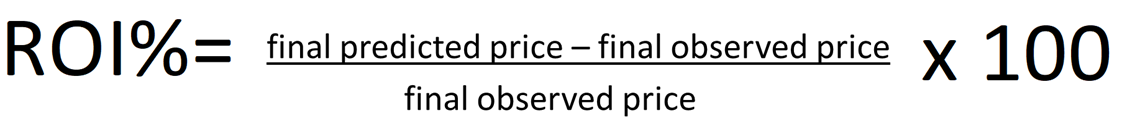

# DATA UNDERSTANDING

To properly model and predict restaurant equity prices in today's world, it's essential to include COVID-19 numbers. There were many "COVID-19 numbers" that I could have used but I decided to use deaths from COVID-19. In another iteration of this work, I may use infection rates but my intuition tells me that people generally worry less about infection nowdays. Basically, increasing infection numbers probably wouldn't alarm consumers but increasing death numbers would deter them from visitng dining establishments in person. 

My COVID-19 death numbers are on a 7 day delay. The reasons are simple: 1:) the CDC takes a week to release results, 2.) the market can take a while to react to COVID numbers. In fact, there is evidence that the market can take very long to react:https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8426993/

I used Yahoo Finance site to obtain my price data. I chose to settle on closing price data although intraday price points could be included as well. Each stock in this dataset has, as a prerequisite for examining 5 years of trading, traded for at least 5 years.

**The main metric I use in this notebook is Mean Absolute Percentage Error(MAPE)** because of its universality. I compare between different models and between different stocks. MAPE is great for comparing between very disparate types of values. I will predict prices using multiple models and therefore I need a metric that will provide useful information between models and stocks inside of models. Other metrics like RMSE and MAE would not be helpful in comparing the model's performance on, for example, Chipotle(currently priced in the 4 digits) and Wendy's (trading around 20 dollars). 

# DATA PREPARATION

First things first: I need to import a plethora of libraries and modules:

In [2]:



import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError 
from tensorflow.keras.optimizers import Adam
from numpy.random import seed
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import itertools
from pmdarima import auto_arima as pm

from pmdarima import model_selection
from numpy import asarray

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

%matplotlib inline
# downloading and opening the excel file with the 5 year data
restaurants = pd. read_excel ("5_year_restaurant_prices.xlsx")
restaurants

Date   McDonalds  Starbucks    Chipotle        Yum  \
0    2017-09-27  154.050003  54.990002  313.850006  73.099998   
1    2017-09-28  157.490005  54.500000  316.529999  73.500000   
2    2017-09-29  156.679993  53.709999  307.829987  73.610001   
3    2017-10-02  156.960007  53.810001  301.809998  73.750000   
4    2017-10-03  156.860001  53.990002  302.989990  73.919998   
...         ...         ...        ...         ...        ...   
1330 2022-12-26         NaN        NaN         NaN        NaN   
1331 2022-12-27         NaN        NaN         NaN        NaN   
1332 2022-12-28         NaN        NaN         NaN        NaN   
1333 2022-12-29         NaN        NaN         NaN        NaN   
1334 2022-12-30         NaN        NaN         NaN        NaN   

      Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
0                 63.869999  79.150002  196.839996   15.58  33.540001   
1                 63.880001  78.959999  197.039993   15.57  33.340000   
2                 63.880001  78.779999  198.550003   15.53  33.250000   
3                 64.269997  79.169998  199.990005   15.29  33.610001   
4                 64.040001  80.110001  202.809998   15.47  33.480000   
...                     ...        ...         ...     ...        ...   
1330                    NaN        NaN         NaN     NaN        NaN   
1331                    NaN        NaN         NaN     NaN        NaN   
1332                    NaN        NaN         NaN     NaN        NaN   
1333                    NaN        NaN         NaN     NaN        NaN   
1334                    NaN        NaN         NaN     NaN        NaN   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      74.699997      149.550003    32.580002       17.420000       100.199997  
1      73.660004      150.399994    32.950001       17.510000       101.040001  
2      73.070000      151.619995    33.230000       17.600000       101.919998  
3      72.559998      153.899994    33.389999       17.639999       100.589996  
4      70.610001      153.210007    33.139999       17.170000        99.339996  
...          ...             ...          ...             ...              ...  
1330         NaN             NaN          NaN             NaN              NaN  
1331         NaN             NaN          NaN             NaN              NaN  
1332         NaN             NaN          NaN             NaN              NaN  
1333         NaN             NaN          NaN             NaN              NaN  
1334         NaN             NaN          NaN             NaN              NaN  

[1335 rows x 15 columns]

In [3]:
restaurants.iloc[1267:]

Date  McDonalds  Starbucks  Chipotle  Yum  Restaurant Brands Int  \
1267 2022-10-10        NaN        NaN       NaN  NaN                    NaN   
1268 2022-10-11        NaN        NaN       NaN  NaN                    NaN   
1269 2022-10-12        NaN        NaN       NaN  NaN                    NaN   
1270 2022-10-13        NaN        NaN       NaN  NaN                    NaN   
1271 2022-10-14        NaN        NaN       NaN  NaN                    NaN   
...         ...        ...        ...       ...  ...                    ...   
1330 2022-12-26        NaN        NaN       NaN  NaN                    NaN   
1331 2022-12-27        NaN        NaN       NaN  NaN                    NaN   
1332 2022-12-28        NaN        NaN       NaN  NaN                    NaN   
1333 2022-12-29        NaN        NaN       NaN  NaN                    NaN   
1334 2022-12-30        NaN        NaN       NaN  NaN                    NaN   

      Darden  Dominos  Wendys  Wingstop  Papa Johns  Cracker Barrel  \
1267     NaN      NaN     NaN       NaN         NaN             NaN   
1268     NaN      NaN     NaN       NaN         NaN             NaN   
1269     NaN      NaN     NaN       NaN         NaN             NaN   
1270     NaN      NaN     NaN       NaN         NaN             NaN   
1271     NaN      NaN     NaN       NaN         NaN             NaN   
...      ...      ...     ...       ...         ...             ...   
1330     NaN      NaN     NaN       NaN         NaN             NaN   
1331     NaN      NaN     NaN       NaN         NaN             NaN   
1332     NaN      NaN     NaN       NaN         NaN             NaN   
1333     NaN      NaN     NaN       NaN         NaN             NaN   
1334     NaN      NaN     NaN       NaN         NaN             NaN   

      Shake Shack  Bloomin Brands  Jack in the Box  
1267          NaN             NaN              NaN  
1268          NaN             NaN              NaN  
1269          NaN             NaN              NaN  
1270          NaN             NaN              NaN  
1271          NaN             NaN              NaN  
...           ...             ...              ...  
1330          NaN             NaN              NaN  
1331          NaN             NaN              NaN  
1332          NaN             NaN              NaN  
1333          NaN             NaN              NaN  
1334          NaN             NaN              NaN  

[68 rows x 15 columns]

The null values in the latter part of the DataFrame represent future data points that have not yet come but will be predicted. Next, it's important to set the "Date" column to a datetime when using a time series:

In [4]:
restaurants['Date'] =pd.to_datetime(restaurants['Date'])

Next, "Date" must be made the index:

In [5]:
restaurants.index= restaurants['Date']
restaurants.drop(['Date'],axis=1, inplace=True)

Let's do some exploration and check for stationarity:

In [6]:
def dftest_stationarity(data):
    for x in data:
        # Check to see if the p-value ≤ .05. If so, it returns the the stationary zipcodes with associated values.
        if  adfuller(data[x])[1] <=.05: 
            return(x, adfuller(data[x])[0:6])
        

In [7]:
dftest_stationarity(restaurants.iloc[:1267].fillna(0))

('Restaurant Brands Int',
 (-3.2387994131264457,
  0.017845835632014112,
  12,
  1254,
  {'1%': -3.4355754676859886,
   '5%': -2.8638475772391665,
   '10%': -2.5679985805677017},
  3594.1956707712025))

Only Restaurant Brands Int is stationary.

In [8]:
# Checking for stationarity on log scaled data
restaurants_log=np.log(restaurants.iloc[:1267].fillna(0))
dftest_stationarity(restaurants_log)

('Restaurant Brands Int',
 (-3.57451147226002,
  0.006267432248044325,
  16,
  1250,
  {'1%': -3.435592223709696, '5%': -2.8638549702604803, '10%': -2.56800251776},
  -6259.063295187531))

Again, only Restaurant Brands Int is stationary.

In [9]:
# Checking for stationarity on square root data

restaurants_sqrt = np.sqrt(restaurants.iloc[:1267].fillna(0))
dftest_stationarity(restaurants_sqrt)

('Restaurant Brands Int',
 (-3.460165355062584,
  0.009071043465808885,
  12,
  1254,
  {'1%': -3.4355754676859886,
   '5%': -2.8638475772391665,
   '10%': -2.5679985805677017},
  -3080.094514204029))

Once again, only Restaurant Brands International is stationary.

Next, I will import the death numbers into the DataFrame:

# COVID-19 MODELING

Now, let's take a look at the covid death numbers:

In [10]:
ts = pd.read_excel ("7day delay.xlsx")
# Making column 'ds' into a datetime
ts['ds'] =pd.to_datetime(ts['ds'])
ts

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

Ok, as you can see, there are no numbers yet for future dates. We will have to predict those.

Let's make a copy of the dataset

In [11]:
ts_copy=ts.copy(deep=True)

ts_copy['ds'] =pd.to_datetime(ts_copy['ds'])
#ts_copy.index= ts_copy['ds']
#ts_copy.drop(['ds'],axis=1, inplace=True)
ts_copy.index
ts_copy

ds    y
0    2020-01-23  0.0
1    2020-01-24  0.0
2    2020-01-25  0.0
3    2020-01-26  0.0
4    2020-01-27  0.0
...         ...  ...
1050 2022-12-26  NaN
1051 2022-12-27  NaN
1052 2022-12-28  NaN
1053 2022-12-29  NaN
1054 2022-12-30  NaN

[1055 rows x 2 columns]

Let's use the square root of the death numbers:

In [12]:
ts_sqrt=ts.copy(deep=True)
ts_sqrt['y']=np.sqrt(ts_sqrt['y'])
ts_sqrt.iloc[989:]

ds   y
989  2022-10-12 NaN
990  2022-10-13 NaN
991  2022-10-14 NaN
992  2022-10-17 NaN
993  2022-10-18 NaN
...         ...  ..
1050 2022-12-26 NaN
1051 2022-12-27 NaN
1052 2022-12-28 NaN
1053 2022-12-29 NaN
1054 2022-12-30 NaN

[66 rows x 2 columns]

Let's set the index for ts to the 'ds' column because we may have to use this DataFrame later.

In [13]:
ts.set_index('ds', inplace=True)

## Prophet

Now let's use Facebook's Prophet to examine the COVID numbers:

In [14]:
from prophet import Prophet

covid_model = Prophet(interval_width=0.95)
covid_model.fit(ts_sqrt.iloc[:923])

Importing plotly failed. Interactive plots will not work.
14:16:57 - cmdstanpy - INFO - Chain [1] start processing
14:16:57 - cmdstanpy - INFO - Chain [1] done processing


Let's look at the results on the training and test data:

Prophet COVID MAEP: 42.887


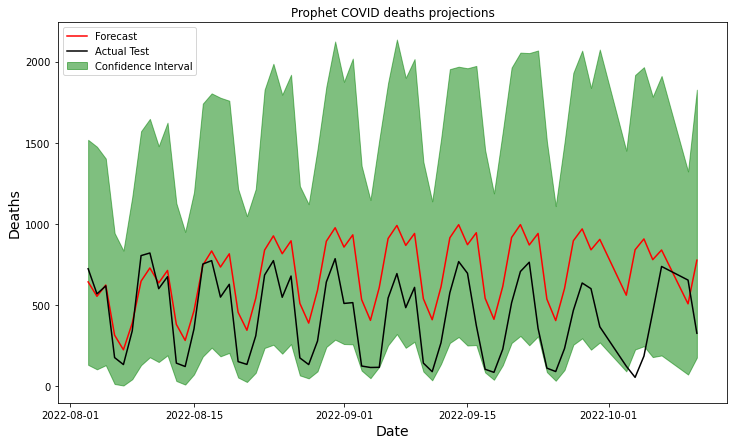

In [15]:
from datetime import datetime
from pandas import DataFrame

from pandas import to_datetime
# Using 66 dates because that is the number of values we need to predict for on the unseen data
future = DataFrame(ts.index[923:989])
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast =  covid_model.predict(future)
# Calculating the MAPE
# Values from DataFrame 'forecast' must be squared to compare with original data

print("Prophet COVID MAEP: %.3f" % (mean_absolute_percentage_error(forecast['yhat']**2,ts.iloc[923:989] )*100))
prophet_covid_mape=mean_absolute_percentage_error(forecast['yhat']**2,ts.iloc[923:989] )*100


# Values from DataFrame 'forecast' must be squared to compare with original data
plt.figure(figsize=(12,7))

plt.plot(ts.index[923:989],forecast['yhat']**2, 'r')
plt.plot(ts.index[923:989], ts.iloc[923:989], 'black')
plt.fill_between(ts.index[923:989], forecast['yhat_upper']**2, forecast['yhat_lower']**2, color="green", alpha=0.5)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Deaths',fontsize=14)
plt.legend(['Forecast','Actual Test', 'Confidence Interval'], loc='upper left')    
plt.title('Prophet COVID deaths projections')

plt.show()


Prophet is easy to use and provides a simple forecast. Now let's predict on the year's remaining dates:

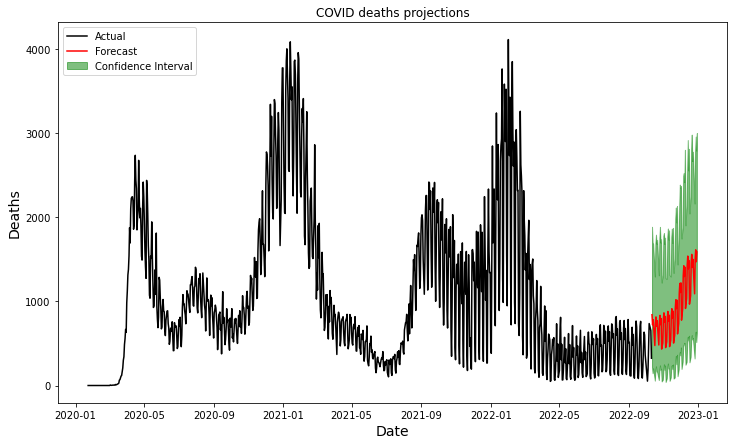

In [16]:

out_of_sample = DataFrame(ts.index[989:1055])
out_of_sample['ds']= to_datetime(out_of_sample['ds'])

predictions=covid_model.predict(out_of_sample)
plt.figure(figsize=(12,7))
plt.plot(ts.index[:989],ts['y'].iloc[:989], 'black')

plt.plot(ts.index[989:1055],predictions['yhat']**2, 'r')
plt.fill_between(ts.index[989:1055], predictions['yhat_upper']**2, predictions['yhat_lower']**2, color="green", alpha=0.5)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Deaths',fontsize=14)
plt.legend(['Actual','Forecast','Confidence Interval'], loc='upper left')    
plt.title('COVID deaths projections')

plt.show()

That's not bad but I'd like to do better. Next, I'll try an LSTM:

In [17]:
#Setting the index to 'ds' so the DataFrame can be used in an LSTM
ts_sqrt.set_index('ds', inplace=True)


In order to use an LSTM, I need to make the values of the DataFrame into a tensor. That's the next task:

In [18]:
# Making the DataFrame values into tensors
def create_dataset(X, y, lag=1):
    #Creating a split into an x(dependent variable) and a y(predicted/independent variable)
    xs,ys = [], []
    #For loop to append on each value of the DataFrame
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

(913, 1) is train shape
Epoch 1/10
91/91 [==============================] - 4s 10ms/step - loss: 135.0116
Epoch 2/10
91/91 [==============================] - 1s 11ms/step - loss: 53.3933
Epoch 3/10
91/91 [==============================] - 1s 11ms/step - loss: 42.6702
Epoch 4/10
91/91 [==============================] - 1s 16ms/step - loss: 40.1535
Epoch 5/10
91/91 [==============================] - 1s 11ms/step - loss: 35.9713
Epoch 6/10
91/91 [==============================] - 1s 13ms/step - loss: 36.8036
Epoch 7/10
91/91 [==============================] - 1s 9ms/step - loss: 32.2864
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 27.6927
Epoch 9/10
91/91 [==============================] - 1s 8ms/step - loss: 25.5620
Epoch 10/10
3/3 [==============================] - 0s 8ms/step
Deaths LSTM MAPE: 147.676


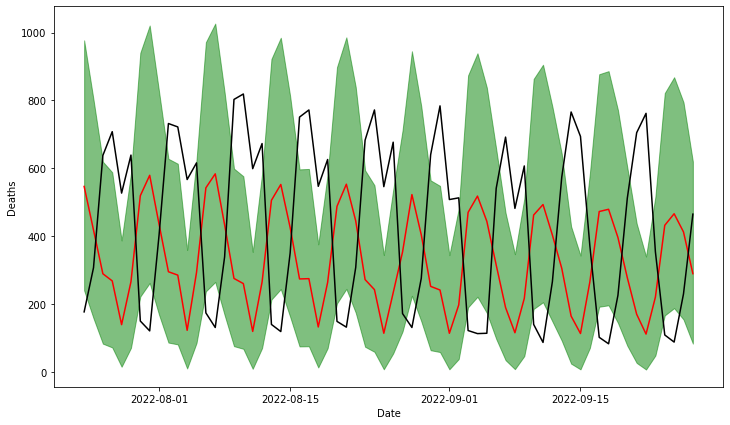

In [19]:

training = ts_sqrt.iloc[:913]
training
#testing = exogenous_df.iloc[1158:1208]
next_= ts_sqrt.iloc[913:989].fillna(0)
print(training.shape, 'is train shape')

xtrain, ytrain = create_dataset(training, training.iloc[:,0], 10)
xnext, ynext=create_dataset(next_, next_.iloc[:,0],10)

model = Sequential()
model.add(LSTM(76,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

model.fit(xtrain, ytrain,
          epochs=10,
          batch_size=10,
          verbose=1,
          shuffle=False
         )

ypred = model.predict(xnext)

ypred = asarray(ypred)
for x in ypred[:]:
    interval = 1.96 * ypred.std()
    lower, upper = ypred - interval, ypred + interval

plt.figure(figsize=(12,7))
#10 values are lost due to lag. 
plt.plot(ts_sqrt.index[913:979], ypred**2, 'r', label="Predictions")
plt.plot(ts_sqrt.index[913:979], next_.iloc[:66,0]**2, 'black', label="Actual")
plt.fill_between(ts_sqrt.index[913:979], lower[:66, 0]**2, upper[:66, 0]**2, color="green", alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Deaths")

print("Deaths LSTM MAPE: %.3f" % (mean_absolute_percentage_error(ypred**2, next_.iloc[:66,0]**2)*100))


That isn't what I was hoping for. That number is too high. The MAPE remains too high. Even running the model multiple times, I obtain results that are too high. It's probably best to use the Prophet model.

Here's how my predictions compare. Note, the predictions at this website are for 4 weeks intervals. 

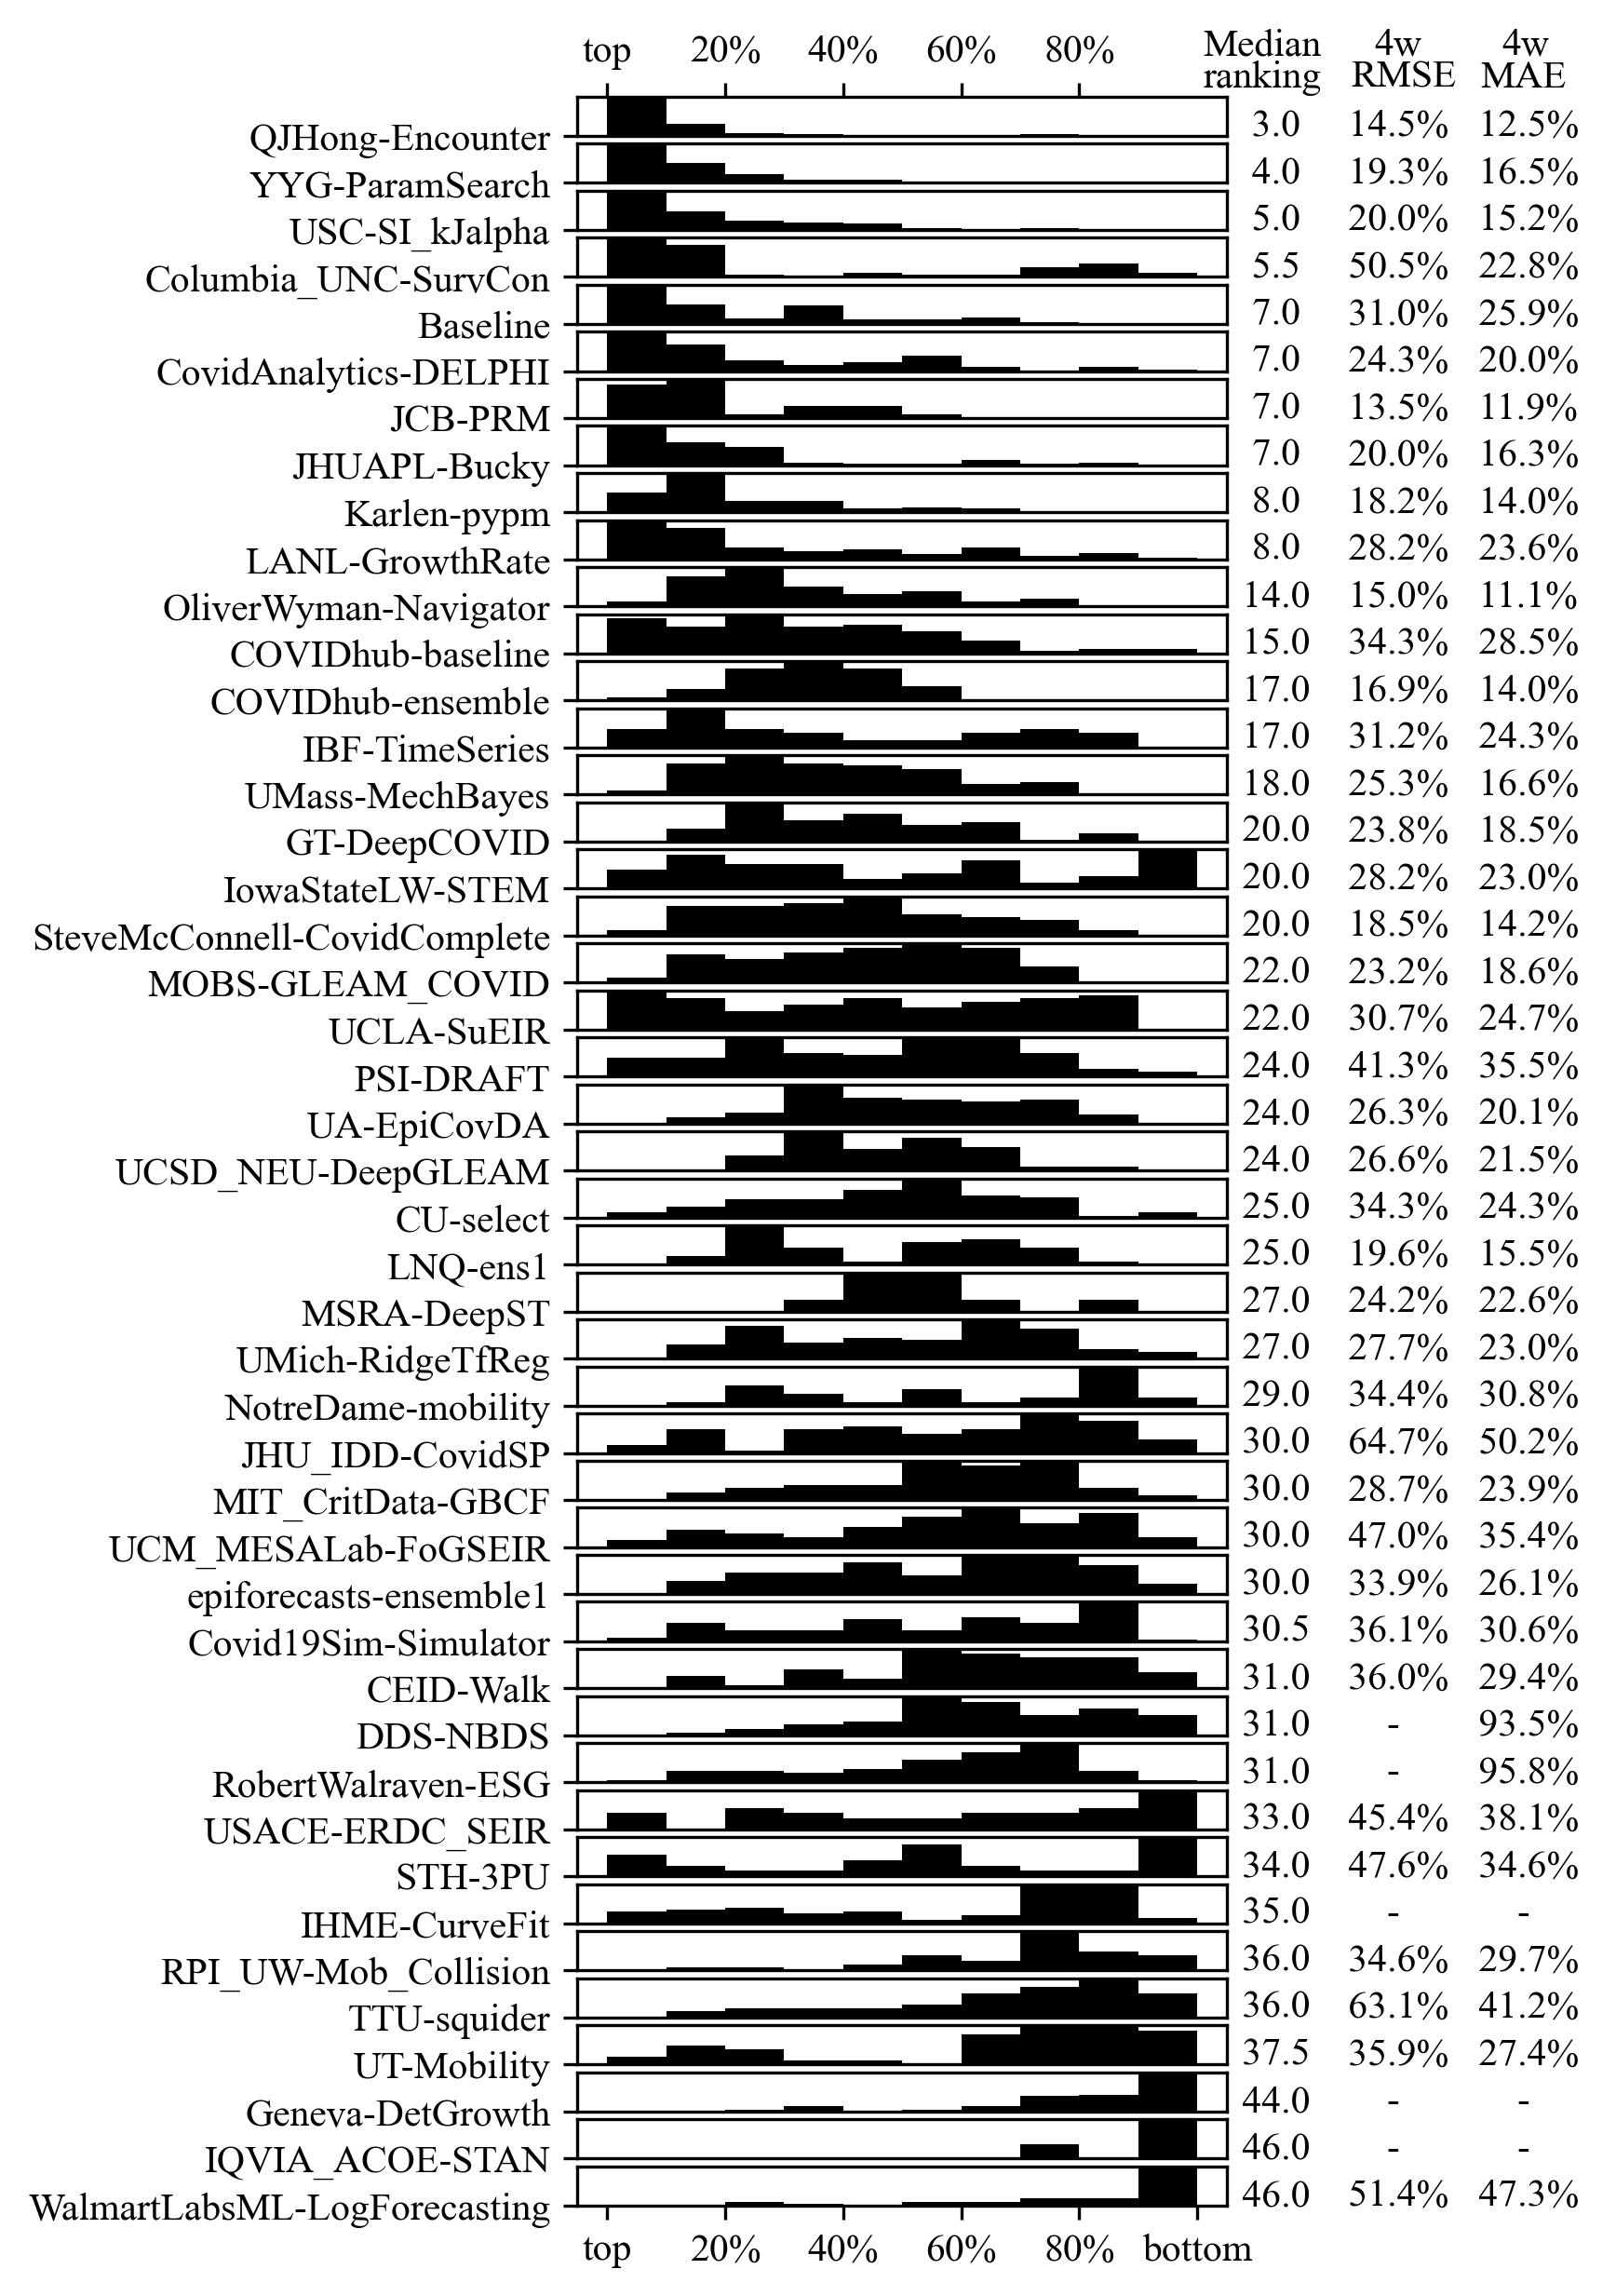

Source:https://qjhong.github.io/

**OK, now that I have predictions, let's model the price data!**

# PRICE MODELING

## Auto-Arima

The 1st model I will employ is an Auto-Arima model.

Let's merge the price data with the death data:

In [20]:
# Merge on restaurants index.
merged=restaurants.merge(ts, how='left',left_on=restaurants.index, right_on=ts.index)
#Filling any null with 0.
merged.fillna(0, inplace=True)
#Renaming the "y" column in ts_copy with deaths
merged.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
merged.set_index('Dates', inplace=True)
merged

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-12-26         0.000000     0.0  
2022-12-27         0.000000     0.0  
2022-12-28         0.000000     0.0  
2022-12-29         0.000000     0.0  
2022-12-30         0.000000     0.0  

[1335 rows x 15 columns]

Making a copy and setting its index to 'Dates':

In [21]:
merged_copy=merged.copy(deep=True)
#merged_copy.set_index('Dates', inplace=True)
merged_copy

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-12-26         0.000000     0.0  
2022-12-27         0.000000     0.0  
2022-12-28         0.000000     0.0  
2022-12-29         0.000000     0.0  
2022-12-30         0.000000     0.0  

[1335 rows x 15 columns]

In [22]:
# A Dataframe with no future values
merged_insample=merged.iloc[:1267,:]
#merged_insample.set_index('Dates', inplace=True)
merged_insample.asfreq('d').index
merged_insample

McDonalds  Starbucks     Chipotle         Yum  \
Dates                                                        
2017-09-27  154.050003  54.990002   313.850006   73.099998   
2017-09-28  157.490005  54.500000   316.529999   73.500000   
2017-09-29  156.679993  53.709999   307.829987   73.610001   
2017-10-02  156.960007  53.810001   301.809998   73.750000   
2017-10-03  156.860001  53.990002   302.989990   73.919998   
...                ...        ...          ...         ...   
2022-10-03  235.340000  85.620000  1468.160000  109.110000   
2022-10-04  238.500000  88.510000  1524.200000  111.410000   
2022-10-05  239.090000  90.120000  1495.860000  112.330000   
2022-10-06  234.750000  89.350000  1506.010000  110.120000   
2022-10-07  233.190000  87.030000  1465.310000  108.930000   

            Restaurant Brands Int      Darden     Dominos  Wendys    Wingstop  \
Dates                                                                           
2017-09-27              63.869999   79.150002  196.839996   15.58   33.540001   
2017-09-28              63.880001   78.959999  197.039993   15.57   33.340000   
2017-09-29              63.880001   78.779999  198.550003   15.53   33.250000   
2017-10-02              64.269997   79.169998  199.990005   15.29   33.610001   
2017-10-03              64.040001   80.110001  202.809998   15.47   33.480000   
...                           ...         ...         ...     ...         ...   
2022-10-03              54.110000  125.410000  316.440000   18.95  123.030000   
2022-10-04              55.480000  132.220000  330.610000   19.47  128.760000   
2022-10-05              55.130000  133.100000  335.130000   19.56  137.650000   
2022-10-06              53.580000  129.510000  324.220000   19.54  133.040000   
2022-10-07              52.310000  125.690000  314.520000   19.10  128.320000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-10-03   73.450000       91.410000    45.630000       18.440000   
2022-10-04   75.560000       97.150000    46.560000       19.600000   
2022-10-05   74.430000       96.450000    46.460000       19.890000   
2022-10-06   71.810000       95.010000    47.840000       19.680000   
2022-10-07   68.680000       91.450000    46.690000       19.360000   

            Jack in the Box  deaths  
Dates                                
2017-09-27       100.199997     0.0  
2017-09-28       101.040001     0.0  
2017-09-29       101.919998     0.0  
2017-10-02       100.589996     0.0  
2017-10-03        99.339996     0.0  
...                     ...     ...  
2022-10-03        72.630000   121.0  
2022-10-04        77.130000    52.0  
2022-10-05        77.700000   183.0  
2022-10-06        75.400000   455.0  
2022-10-07        74.750000   736.0  

[1267 rows x 15 columns]

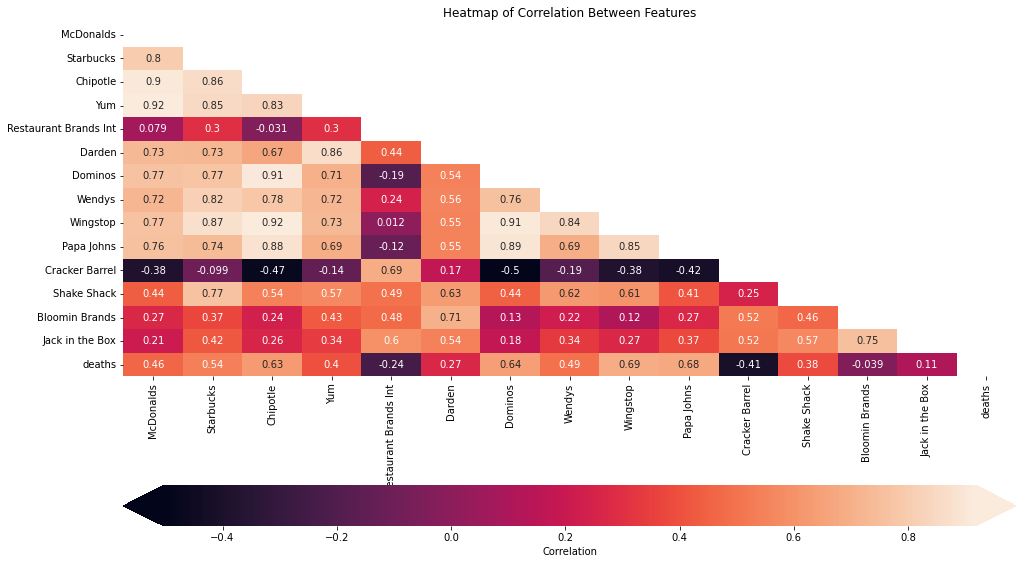

In [23]:
#Correlations
stock_deaths_corr = merged_insample.corr()
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    data=stock_deaths_corr,
    mask=np.triu(np.ones_like(stock_deaths_corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
ax.set_title("Heatmap of Correlation Between Features");

In [24]:
print(1267-(69*2), 'training days for all models')


1129 training days for all models


In [25]:
%%time

error_dict_percent=dict();
def stonks(stocks):
    # train size= 1-(138/1267)=0.8910812943962115
    train, test = model_selection.train_test_split(stocks, train_size= 0.8910812943962115 )
    # Auto_arima from: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # Default criterion is AIC.
    model_0 = pm(train, exogenous= merged_insample[['deaths']].iloc[:1129], start_p=1, start_q=1, start_P=1, start_Q=1,
                 max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,stepwise=True, suppress_warnings=True, 
                 D=5, max_D=5,error_action='ignore')
    #printing model summary
    print(model_0.summary())
    #Creating the predictions. 
    #conf_int returns confidence level at 95% level.
    preds_0, conf_int = model_0.predict(n_periods=69, exogenous= merged_copy[['deaths']].iloc[1129 :1198], 
                                        return_conf_int=True)
    
    
    #Print the errors:

    print("Validation MAPE: %.3f" % np.sqrt(mean_absolute_percentage_error(test.iloc[:69], preds_0)*100))
    print("Validation MAE: %.3f" % (mean_absolute_error(test.iloc[:69], preds_0)))
    percent_error=mean_absolute_percentage_error(test.iloc[:69], preds_0)*100

   

    plt.figure(figsize=(12,6))
    plt.plot(merged_insample.index[:1129], train)
    plt.plot(merged_insample.index[1129 :1198], test.iloc[:69])
    plt.plot(merged_insample.index[1129 :1198], preds_0)
    plt.fill_between(merged_insample.index[1129 :1198], conf_int[:, 0], conf_int[:, 1], color="purple", alpha=0.5)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Home Value',fontsize=14)
    plt.legend(['Train','Test', 'Predictions', 'Confidence Interval'], loc='upper left')    
    plt.title(f'{stocks.name} Price')
    plt.ticklabel_format(axis='y',style='plain',useOffset=False)
    plt.show()
    error_dict_percent[stocks.name]=percent_error

stop = timeit.default_timer()
    

Wall time: 0 ns


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -2742.890
Date:                Wed, 19 Oct 2022   AIC                           5499.780
Time:                        14:20:51   BIC                           5534.977
Sample:                             0   HQIC                          5513.079
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths     -5.377e-05      0.000     -0.169      0.866      -0.001       0.001
ar.L1         -0.1249      0.018     -7.048      0.000      -0.160      -0.090
ar.L2          0.0738      0.013      5.474      0.0

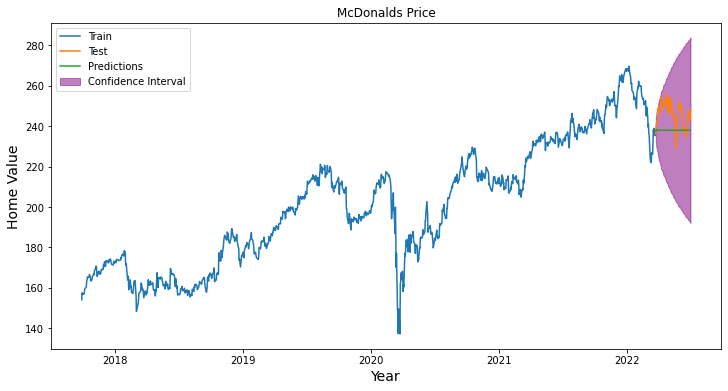

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2024.361
Date:                Wed, 19 Oct 2022   AIC                           4054.722
Time:                        14:20:57   BIC                           4069.807
Sample:                             0   HQIC                          4060.422
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      3.025e-06      0.000      0.024      0.981      -0.000       0.000
ar.L1         -0.1019      0.016     -6.214      0.000      -0.134      -0.070
sigma2         2.1217      0.044     48.424      0.0

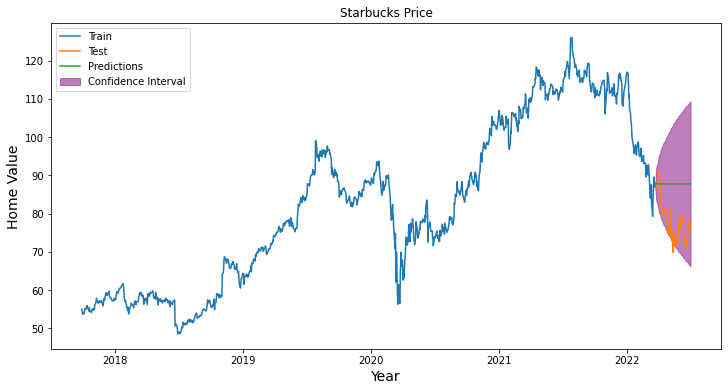

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -5067.621
Date:                Wed, 19 Oct 2022   AIC                          10143.243
Time:                        14:21:01   BIC                          10163.356
Sample:                             0   HQIC                         10150.842
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0507      0.665      1.579      0.114      -0.253       2.355
deaths         0.0051      0.001      3.591      0.000       0.002       0.008
ar.L1          0.0442      0.022      1.976      0.0

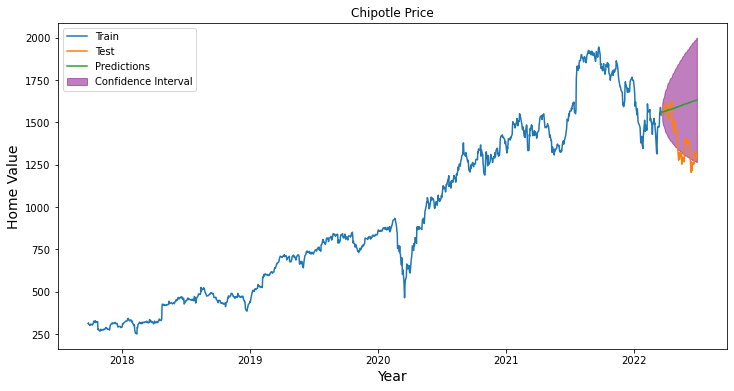

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2028.135
Date:                Wed, 19 Oct 2022   AIC                           4060.269
Time:                        14:21:04   BIC                           4070.325
Sample:                             0   HQIC                          4064.069
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      7.482e-05      0.000      0.531      0.595      -0.000       0.000
sigma2         2.1342      0.037     57.400      0.000       2.061       2.207
Ljung-Box (L1) (Q):                   0.60   Jarque-

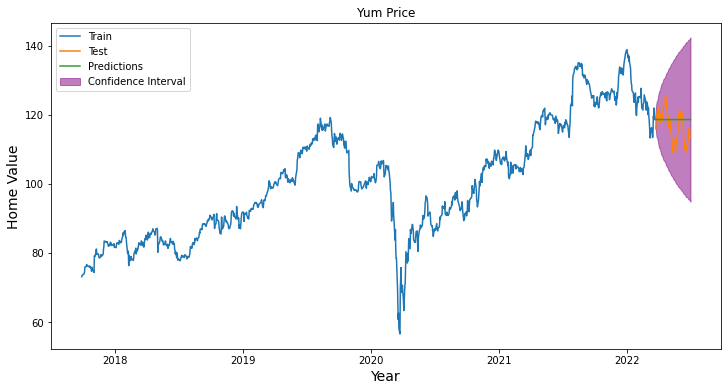

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1660.138
Date:                Wed, 19 Oct 2022   AIC                           3324.276
Time:                        14:21:07   BIC                           3334.333
Sample:                             0   HQIC                          3328.076
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      6.098e-05      0.000      0.546      0.585      -0.000       0.000
sigma2         1.1110      0.018     60.743      0.000       1.075       1.147
Ljung-Box (L1) (Q):                   1.38   Jarque-

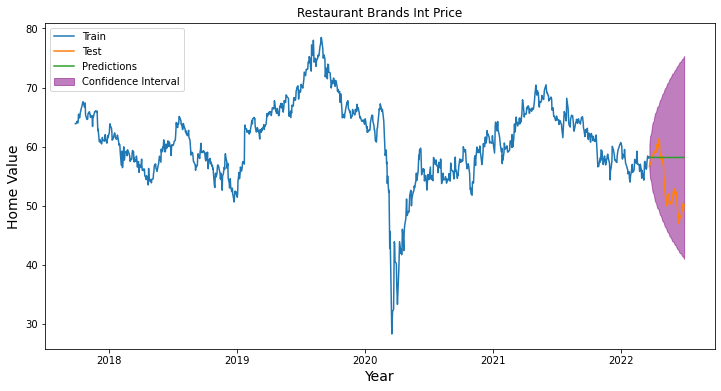

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2636.394
Date:                Wed, 19 Oct 2022   AIC                           5276.787
Time:                        14:21:09   BIC                           5286.844
Sample:                             0   HQIC                          5280.587
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0002      0.000      0.626      0.531      -0.000       0.001
sigma2         6.2751      0.119     52.805      0.000       6.042       6.508
Ljung-Box (L1) (Q):                   0.05   Jarque-

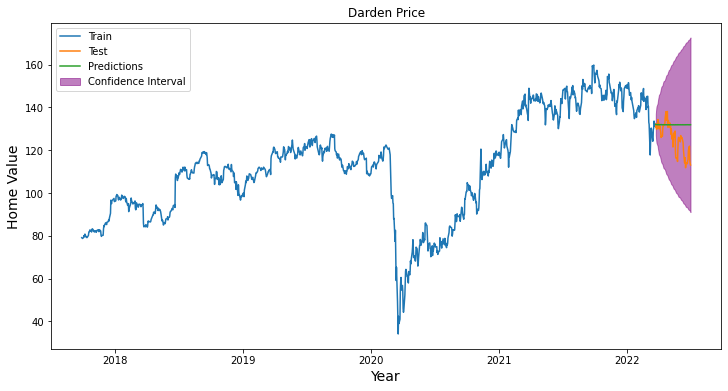

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3755.356
Date:                Wed, 19 Oct 2022   AIC                           7516.713
Time:                        14:21:13   BIC                           7531.797
Sample:                             0   HQIC                          7522.412
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths        -0.0009      0.001     -1.449      0.147      -0.002       0.000
ar.L1         -0.1055      0.023     -4.646      0.000      -0.150      -0.061
sigma2        45.6696      0.528     86.441      0.0

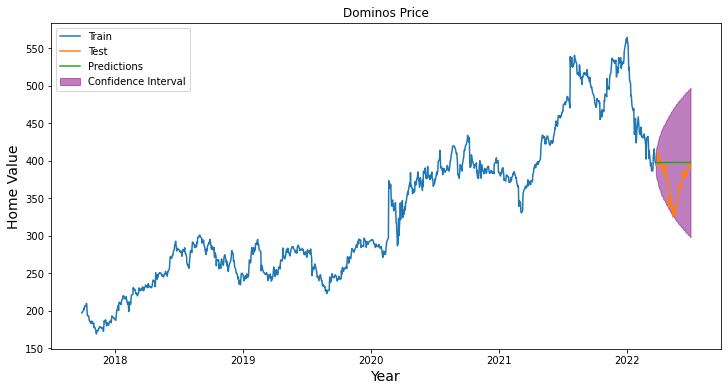

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -738.055
Date:                Wed, 19 Oct 2022   AIC                           1482.110
Time:                        14:21:18   BIC                           1497.194
Sample:                             0   HQIC                          1487.809
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths     -2.079e-05   5.74e-05     -0.362      0.717      -0.000    9.16e-05
ar.L1         -0.0930      0.008    -10.983      0.000      -0.110      -0.076
sigma2         0.2169      0.002    103.493      0.0

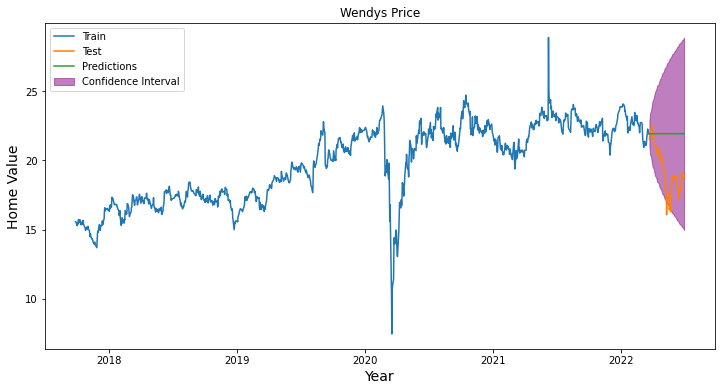

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2803.636
Date:                Wed, 19 Oct 2022   AIC                           5613.273
Time:                        14:21:23   BIC                           5628.358
Sample:                             0   HQIC                          5618.972
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0005      0.000      2.290      0.022    7.15e-05       0.001
ar.L1          0.0716      0.019      3.728      0.000       0.034       0.109
sigma2         8.4485      0.157     53.697      0.0

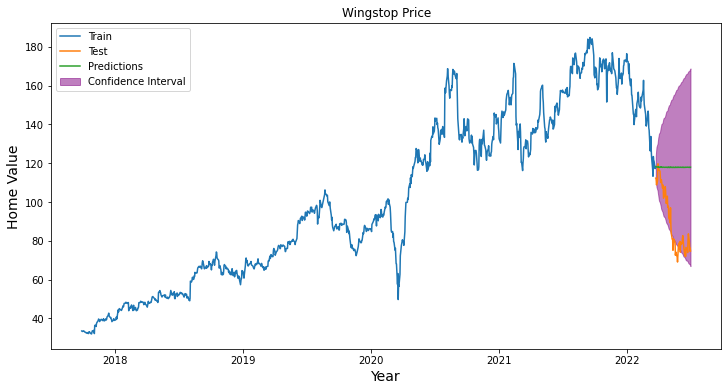

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2333.353
Date:                Wed, 19 Oct 2022   AIC                           4670.705
Time:                        14:21:26   BIC                           4680.762
Sample:                             0   HQIC                          4674.505
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0002      0.000      1.712      0.087   -3.31e-05       0.000
sigma2         3.6650      0.062     58.879      0.000       3.543       3.787
Ljung-Box (L1) (Q):                   2.56   Jarque-

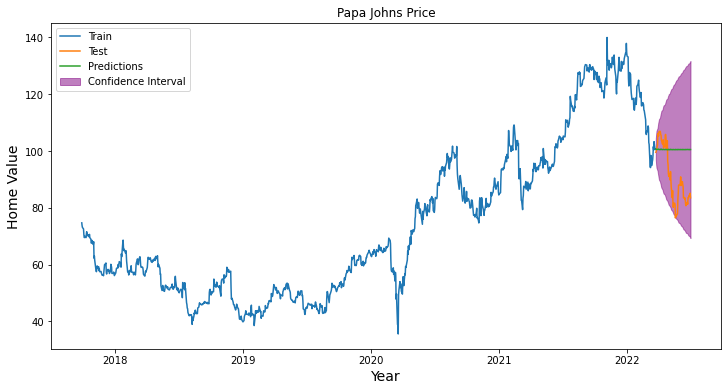

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2882.953
Date:                Wed, 19 Oct 2022   AIC                           5769.906
Time:                        14:21:27   BIC                           5779.962
Sample:                             0   HQIC                          5773.706
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths        -0.0003      0.000     -1.044      0.297      -0.001       0.000
sigma2         9.7157      0.206     47.068      0.000       9.311      10.120
Ljung-Box (L1) (Q):                   1.09   Jarque-

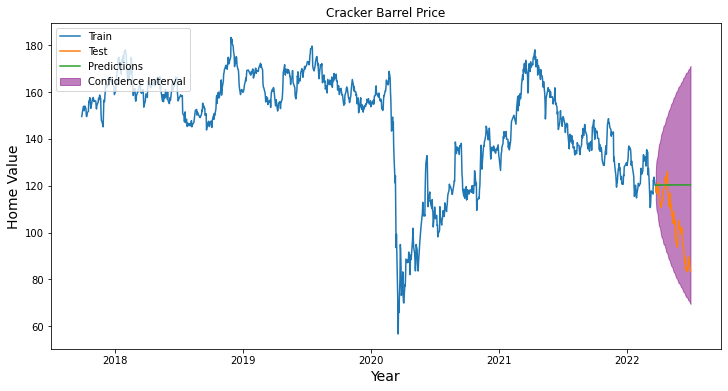

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2562.197
Date:                Wed, 19 Oct 2022   AIC                           5128.395
Time:                        14:21:30   BIC                           5138.451
Sample:                             0   HQIC                          5132.195
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0004      0.000      2.033      0.042    1.27e-05       0.001
sigma2         5.5015      0.097     56.731      0.000       5.311       5.692
Ljung-Box (L1) (Q):                   2.47   Jarque-

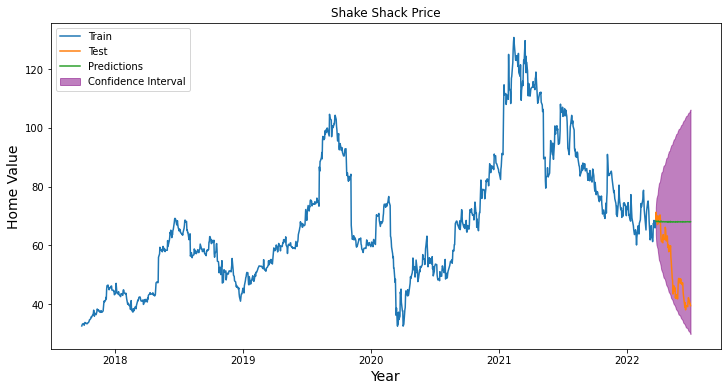

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -972.005
Date:                Wed, 19 Oct 2022   AIC                           1948.010
Time:                        14:21:34   BIC                           1958.067
Sample:                             0   HQIC                          1951.810
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths      9.954e-08   5.83e-05      0.002      0.999      -0.000       0.000
sigma2         0.3285      0.007     45.591      0.000       0.314       0.343
Ljung-Box (L1) (Q):                   2.16   Jarque-

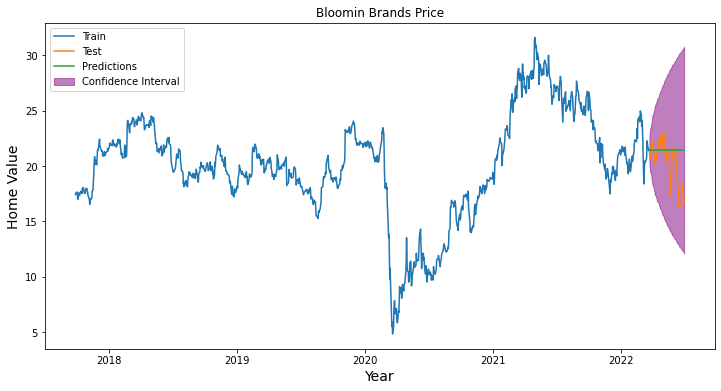

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1129
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2292.341
Date:                Wed, 19 Oct 2022   AIC                           4588.682
Time:                        14:21:35   BIC                           4598.739
Sample:                             0   HQIC                          4592.482
                               - 1129                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
deaths         0.0001      0.000      0.512      0.609      -0.000       0.001
sigma2         3.4095      0.067     51.179      0.000       3.279       3.540
Ljung-Box (L1) (Q):                   1.00   Jarque-

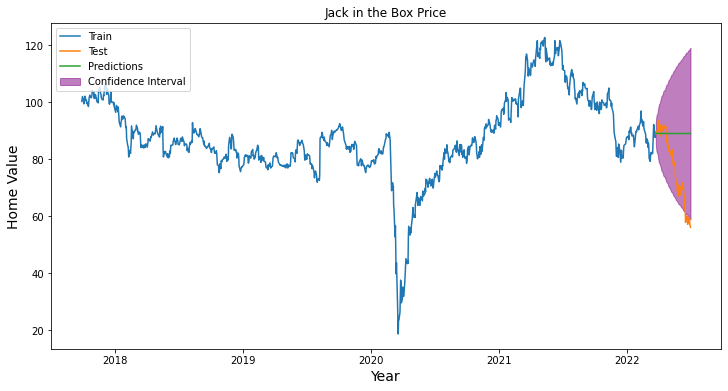

Wall time: 55.7 s


In [26]:
%%time

for x in merged_insample.iloc[:, :14]:
    stonks(merged_insample.iloc[:, :14][x])

stop = timeit.default_timer()

In [27]:
error_dict_percent

{'McDonalds': 3.5504125395317616,
 'Starbucks': 13.49113026935879,
 'Chipotle': 14.667804562345694,
 'Yum': 3.369135385409728,
 'Restaurant Brands Int': 9.558524136737764,
 'Darden': 6.033674052082082,
 'Dominos': 7.3036060445931295,
 'Wendys': 14.873850898016478,
 'Wingstop': 35.081750791712494,
 'Papa Johns': 13.353234960561863,
 'Cracker Barrel': 16.25855580861495,
 'Shake Shack': 34.589714062379734,
 'Bloomin Brands': 7.8227858070856096,
 'Jack in the Box': 18.90909179447443}

In [28]:
# Examining the MAPEs by creating a DataFrame of MAPEs
from operator import itemgetter, attrgetter
stocksss_errors= sorted(error_dict_percent.items(), key=itemgetter(1), reverse=False)
pm_stock_diffs_error_per= pd.DataFrame(stocksss_errors)
pm_stock_diffs_error_per.rename( columns={0 :'Stock', 1:'Auto Arima Percent Error'}, inplace=True )
pm_stock_diffs_error_per['Auto Arima Percent Error'].mean()

14.204519365207462

In [29]:
pm_stock_diffs_error_per

Stock  Auto Arima Percent Error
0                     Yum                  3.369135
1               McDonalds                  3.550413
2                  Darden                  6.033674
3                 Dominos                  7.303606
4          Bloomin Brands                  7.822786
5   Restaurant Brands Int                  9.558524
6              Papa Johns                 13.353235
7               Starbucks                 13.491130
8                Chipotle                 14.667805
9                  Wendys                 14.873851
10         Cracker Barrel                 16.258556
11        Jack in the Box                 18.909092
12            Shake Shack                 34.589714
13               Wingstop                 35.081751

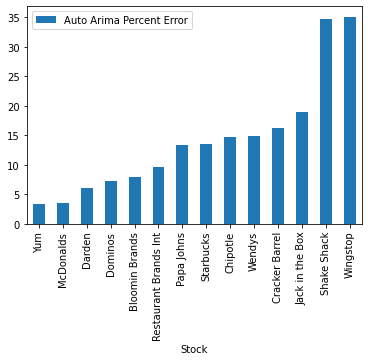

In [30]:
# Graphing MAPEs

pm_stock_diffs_error_per.plot.bar(x='Stock',y='Auto Arima Percent Error');


## Sktime Prophet Modeling

Those results were surprisingly good but maybe Prophet can do better. After all, it was developed with the business cycle in mind. Because the regular Prophet module has trouble with exogenous variables, I instead used Sktime's Prophet which does allow for exogenous variables

In [31]:


from sktime.forecasting.fbprophet import Prophet
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from sktime.performance_metrics.forecasting import     mean_absolute_percentage_error



Next, I will use the Prophet model so I need to reset the index. Therefore, I will make another DataFrame with a reset index

In [32]:
merged_copy_reset=merged_copy.reset_index(drop=False)

merged_copy_reset

Dates   McDonalds  Starbucks    Chipotle        Yum  \
0    2017-09-27  154.050003  54.990002  313.850006  73.099998   
1    2017-09-28  157.490005  54.500000  316.529999  73.500000   
2    2017-09-29  156.679993  53.709999  307.829987  73.610001   
3    2017-10-02  156.960007  53.810001  301.809998  73.750000   
4    2017-10-03  156.860001  53.990002  302.989990  73.919998   
...         ...         ...        ...         ...        ...   
1330 2022-12-26    0.000000   0.000000    0.000000   0.000000   
1331 2022-12-27    0.000000   0.000000    0.000000   0.000000   
1332 2022-12-28    0.000000   0.000000    0.000000   0.000000   
1333 2022-12-29    0.000000   0.000000    0.000000   0.000000   
1334 2022-12-30    0.000000   0.000000    0.000000   0.000000   

      Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
0                 63.869999  79.150002  196.839996   15.58  33.540001   
1                 63.880001  78.959999  197.039993   15.57  33.340000   
2                 63.880001  78.779999  198.550003   15.53  33.250000   
3                 64.269997  79.169998  199.990005   15.29  33.610001   
4                 64.040001  80.110001  202.809998   15.47  33.480000   
...                     ...        ...         ...     ...        ...   
1330               0.000000   0.000000    0.000000    0.00   0.000000   
1331               0.000000   0.000000    0.000000    0.00   0.000000   
1332               0.000000   0.000000    0.000000    0.00   0.000000   
1333               0.000000   0.000000    0.000000    0.00   0.000000   
1334               0.000000   0.000000    0.000000    0.00   0.000000   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
0      74.699997      149.550003    32.580002       17.420000   
1      73.660004      150.399994    32.950001       17.510000   
2      73.070000      151.619995    33.230000       17.600000   
3      72.559998      153.899994    33.389999       17.639999   
4      70.610001      153.210007    33.139999       17.170000   
...          ...             ...          ...             ...   
1330    0.000000        0.000000     0.000000        0.000000   
1331    0.000000        0.000000     0.000000        0.000000   
1332    0.000000        0.000000     0.000000        0.000000   
1333    0.000000        0.000000     0.000000        0.000000   
1334    0.000000        0.000000     0.000000        0.000000   

      Jack in the Box  deaths  
0          100.199997     0.0  
1          101.040001     0.0  
2          101.919998     0.0  
3          100.589996     0.0  
4           99.339996     0.0  
...               ...     ...  
1330         0.000000     0.0  
1331         0.000000     0.0  
1332         0.000000     0.0  
1333         0.000000     0.0  
1334         0.000000     0.0  

[1335 rows x 16 columns]

In [33]:
prophet_error_dict=dict()
def prophet(data):
    y = data.iloc[:1129]
    test_x=data.iloc[1129 :1198]
    #data['floor']=0
    #print(data['floor'])
    forecaster = Prophet(freq='d')
    forecaster.fit(y, X=merged_copy_reset['deaths'].iloc[:1129])
    y_preds = forecaster.predict(fh= np.arange(1, 70), X=merged_copy_reset['deaths'].iloc[1129 :1198])
    
    #forecaster.plot(y_preds)
    coverage = [0.95]
    y_pred_ints = forecaster.predict_interval(fh=np.arange(1, 70),
                                              X=merged_copy_reset['deaths'].iloc[1129 :1198], coverage=0.95)
    y_pred = forecaster.predict(fh= np.arange(1, 70), X=merged_copy_reset['deaths'].iloc[1129 :1198])
    print(f'{data.name}  MAPE: %.3f' % (mean_absolute_percentage_error(test_x, y_preds)))
    prophet_percent_error=mean_absolute_percentage_error(test_x, y_preds)*100
    
    fig, ax = plotting.plot_series(y,test_x, y_pred, labels=["Actual Prices", "Test Values","Predicted Prices"])

    #print(y_pred_ints)
    ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["Coverage"][0.95]["lower"],
    y_pred_ints["Coverage"][0.95]["upper"],
    alpha=0.6,
    color=ax.get_lines()[-1].get_c(),
    label=f"{coverage} cov.pred.intervals",
    )

    ax.legend();
    
    prophet_error_dict[data.name]=prophet_percent_error


In [34]:
merged_copy_reset.iloc[:1266, :15]

Dates   McDonalds  Starbucks     Chipotle         Yum  \
0    2017-09-27  154.050003  54.990002   313.850006   73.099998   
1    2017-09-28  157.490005  54.500000   316.529999   73.500000   
2    2017-09-29  156.679993  53.709999   307.829987   73.610001   
3    2017-10-02  156.960007  53.810001   301.809998   73.750000   
4    2017-10-03  156.860001  53.990002   302.989990   73.919998   
...         ...         ...        ...          ...         ...   
1261 2022-09-30  230.740000  84.260000  1501.070000  106.340000   
1262 2022-10-03  235.340000  85.620000  1468.160000  109.110000   
1263 2022-10-04  238.500000  88.510000  1524.200000  111.410000   
1264 2022-10-05  239.090000  90.120000  1495.860000  112.330000   
1265 2022-10-06  234.750000  89.350000  1506.010000  110.120000   

      Restaurant Brands Int      Darden     Dominos  Wendys    Wingstop  \
0                 63.869999   79.150002  196.839996   15.58   33.540001   
1                 63.880001   78.959999  197.039993   15.57   33.340000   
2                 63.880001   78.779999  198.550003   15.53   33.250000   
3                 64.269997   79.169998  199.990005   15.29   33.610001   
4                 64.040001   80.110001  202.809998   15.47   33.480000   
...                     ...         ...         ...     ...         ...   
1261              53.180000  126.320000  310.200000   18.69  125.420000   
1262              54.110000  125.410000  316.440000   18.95  123.030000   
1263              55.480000  132.220000  330.610000   19.47  128.760000   
1264              55.130000  133.100000  335.130000   19.56  137.650000   
1265              53.580000  129.510000  324.220000   19.54  133.040000   

      Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  Jack in the Box  
0      74.699997      149.550003    32.580002       17.420000       100.199997  
1      73.660004      150.399994    32.950001       17.510000       101.040001  
2      73.070000      151.619995    33.230000       17.600000       101.919998  
3      72.559998      153.899994    33.389999       17.639999       100.589996  
4      70.610001      153.210007    33.139999       17.170000        99.339996  
...          ...             ...          ...             ...              ...  
1261   70.010000       92.580000    44.980000       18.330000        74.070000  
1262   73.450000       91.410000    45.630000       18.440000        72.630000  
1263   75.560000       97.150000    46.560000       19.600000        77.130000  
1264   74.430000       96.450000    46.460000       19.890000        77.700000  
1265   71.810000       95.010000    47.840000       19.680000        75.400000  

[1266 rows x 15 columns]

14:21:38 - cmdstanpy - INFO - Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing


McDonalds  MAPE: 0.074


14:21:42 - cmdstanpy - INFO - Chain [1] start processing
14:21:43 - cmdstanpy - INFO - Chain [1] done processing


Starbucks  MAPE: 0.234


14:21:46 - cmdstanpy - INFO - Chain [1] start processing
14:21:46 - cmdstanpy - INFO - Chain [1] done processing


Chipotle  MAPE: 0.100


14:21:50 - cmdstanpy - INFO - Chain [1] start processing
14:21:50 - cmdstanpy - INFO - Chain [1] done processing


Yum  MAPE: 0.147


14:21:53 - cmdstanpy - INFO - Chain [1] start processing
14:21:53 - cmdstanpy - INFO - Chain [1] done processing


Restaurant Brands Int  MAPE: 0.091


14:21:56 - cmdstanpy - INFO - Chain [1] start processing
14:21:57 - cmdstanpy - INFO - Chain [1] done processing


Darden  MAPE: 0.228


14:22:00 - cmdstanpy - INFO - Chain [1] start processing
14:22:01 - cmdstanpy - INFO - Chain [1] done processing


Dominos  MAPE: 0.115


14:22:04 - cmdstanpy - INFO - Chain [1] start processing
14:22:04 - cmdstanpy - INFO - Chain [1] done processing


Wendys  MAPE: 0.258


14:22:07 - cmdstanpy - INFO - Chain [1] start processing
14:22:08 - cmdstanpy - INFO - Chain [1] done processing


Wingstop  MAPE: 0.604


14:22:11 - cmdstanpy - INFO - Chain [1] start processing
14:22:12 - cmdstanpy - INFO - Chain [1] done processing


Papa Johns  MAPE: 0.278


14:22:15 - cmdstanpy - INFO - Chain [1] start processing
14:22:16 - cmdstanpy - INFO - Chain [1] done processing


Cracker Barrel  MAPE: 0.358


14:22:18 - cmdstanpy - INFO - Chain [1] start processing
14:22:19 - cmdstanpy - INFO - Chain [1] done processing


Shake Shack  MAPE: 0.526


14:22:22 - cmdstanpy - INFO - Chain [1] start processing
14:22:23 - cmdstanpy - INFO - Chain [1] done processing


Bloomin Brands  MAPE: 0.253


14:22:26 - cmdstanpy - INFO - Chain [1] start processing
14:22:26 - cmdstanpy - INFO - Chain [1] done processing


Jack in the Box  MAPE: 0.120
Wall time: 51.6 s


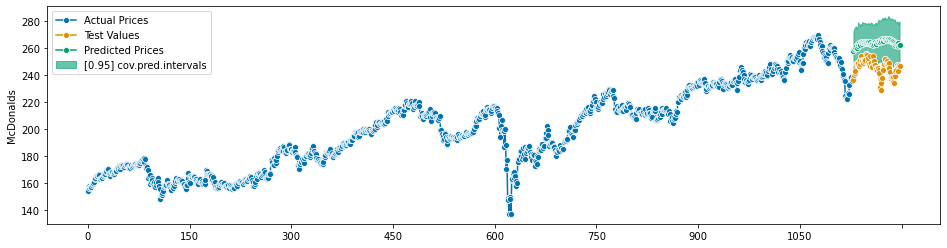

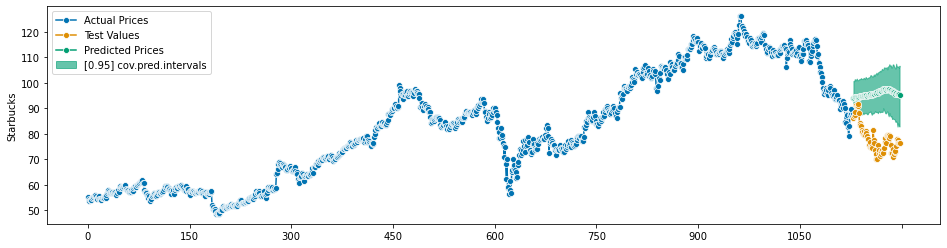

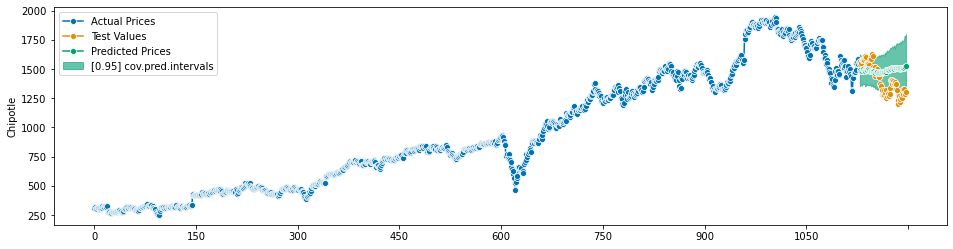

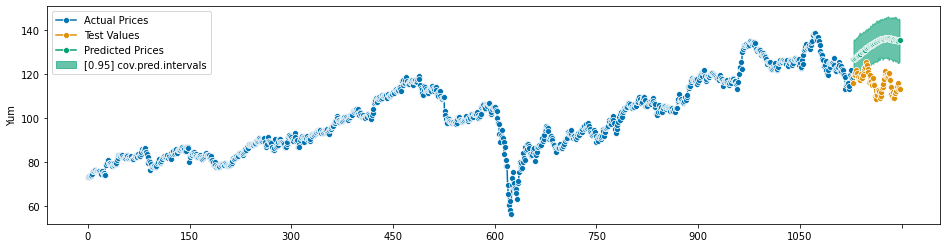

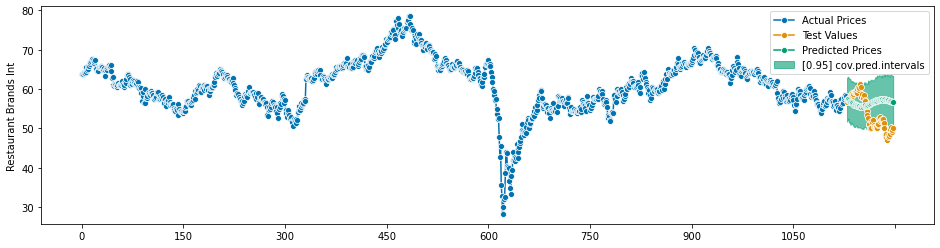

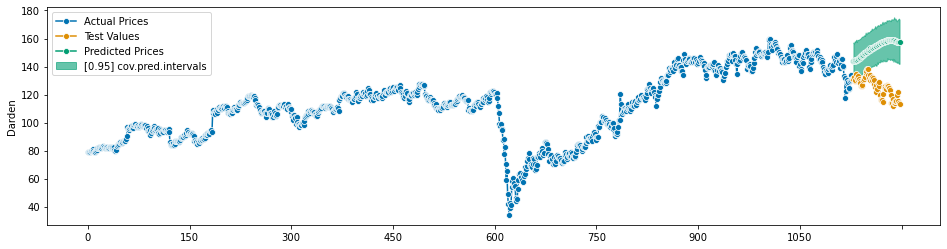

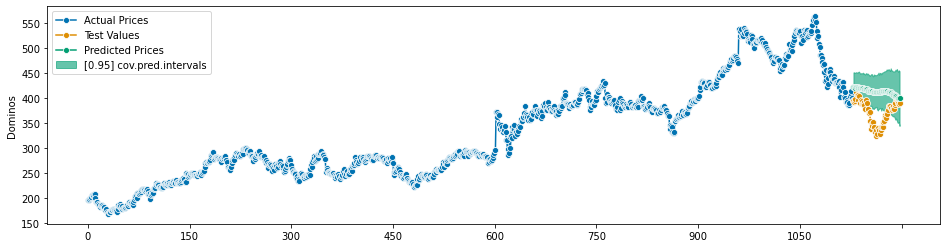

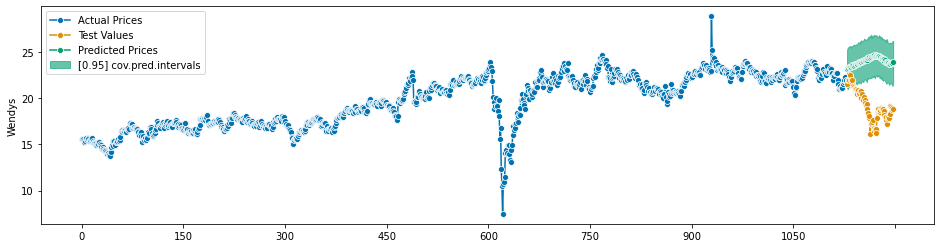

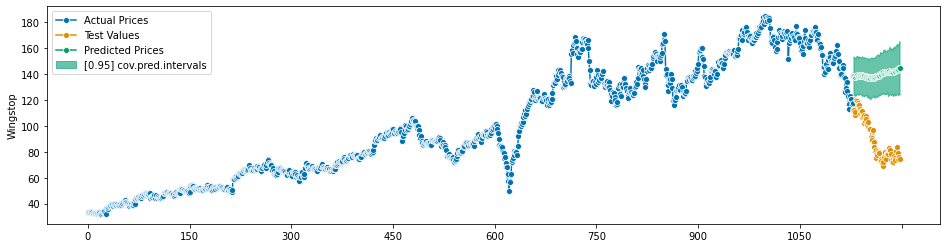

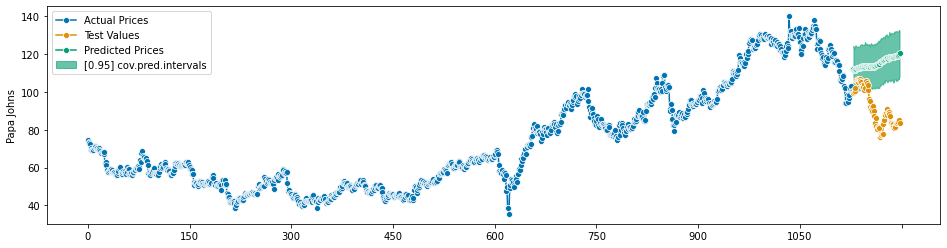

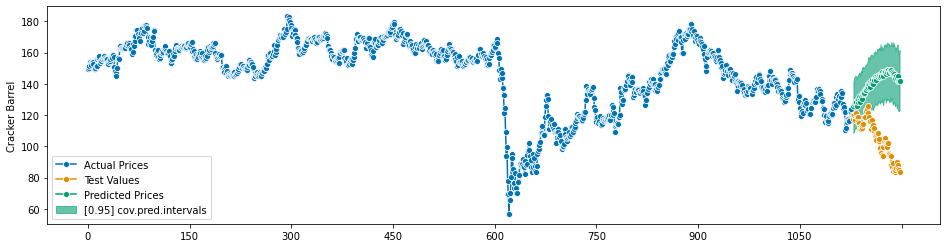

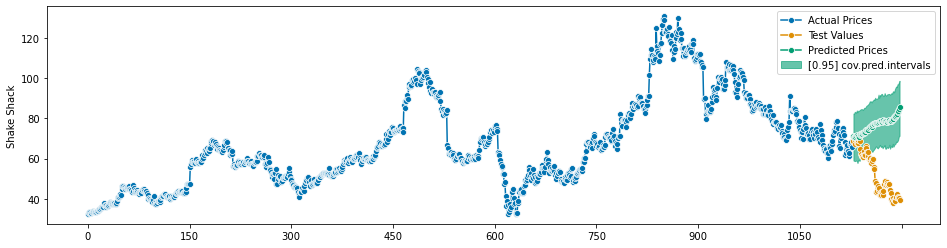

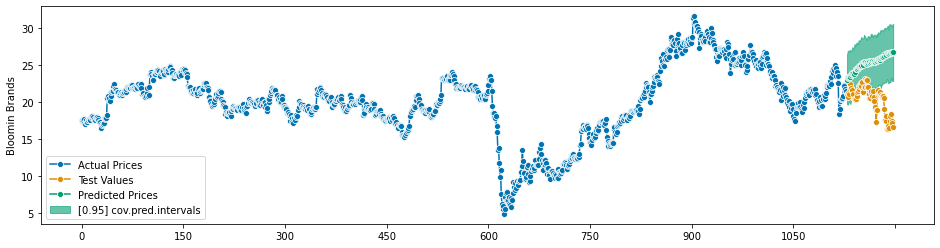

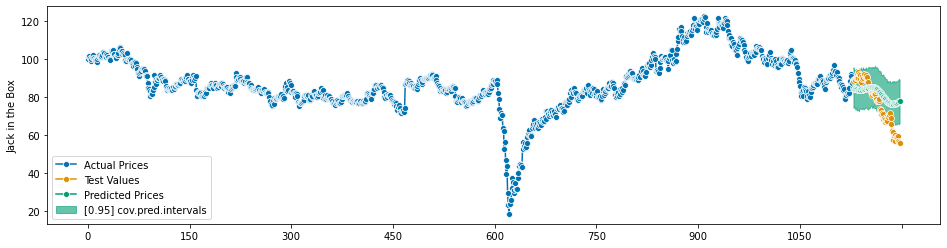

In [35]:
%%time

for x in merged_copy_reset.iloc[:1267, 1:15]:
    prophet(merged_copy_reset.iloc[:1267, 1:15][x])

stop = timeit.default_timer()

In [36]:
prophet_error_dict

{'McDonalds': 7.417765323981176,
 'Starbucks': 23.410977057345043,
 'Chipotle': 9.964098767561582,
 'Yum': 14.749784051995613,
 'Restaurant Brands Int': 9.116141186207523,
 'Darden': 22.84544018420461,
 'Dominos': 11.45956267818712,
 'Wendys': 25.81117959170662,
 'Wingstop': 60.43600823622859,
 'Papa Johns': 27.834162960601965,
 'Cracker Barrel': 35.84510343436148,
 'Shake Shack': 52.601364362965484,
 'Bloomin Brands': 25.277164800499907,
 'Jack in the Box': 12.006046206212414}

In [37]:
#A DataFrame of prophet MAPEs
prophet_errors= sorted(prophet_error_dict.items(), key=itemgetter(1), reverse=False)
pro_stock_diffs_error_per= pd.DataFrame(prophet_errors)
pro_stock_diffs_error_per.rename( columns={0 :'Stock', 1:'Prophet Percent Error'}, inplace=True )
pro_stock_diffs_error_per.mean()


Prophet Percent Error    24.1982
dtype: float64

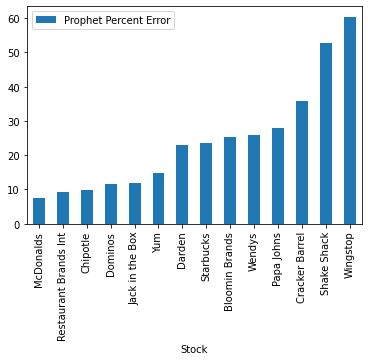

In [38]:
# Sktime Prophet MAPEs graph
pro_stock_diffs_error_per.plot.bar(x='Stock',y='Prophet Percent Error');

We can see that the MAPEs are too high to be used. Let's try another model:

# LSTM

First, let's incorporate the death predictions into the data:

In [39]:
death_preds = pd. read_excel ("7day_delay_withmy_preds.xlsx")
death_preds.set_index('ds', inplace=True)
death_preds

y
ds                     
2020-01-23     0.000000
2020-01-24     0.000000
2020-01-25     0.000000
2020-01-26     0.000000
2020-01-27     0.000000
...                 ...
2022-12-26  2188.014113
2022-12-27  2910.569217
2022-12-28  2910.907724
2022-12-29  2911.805639
2022-12-30  2953.894081

[1055 rows x 1 columns]

In [40]:
#Merger of death preds and 
merged_preds=restaurants.merge(death_preds, how='left',left_on=restaurants.index, right_on=death_preds.index)
merged_preds.fillna(0, inplace=True)
merged_preds.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
#merged_copy=merged.copy(deep=True)
merged_preds.set_index('Dates', inplace=True)
merged_preds


McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26    0.000000   0.000000    0.000000   0.000000   
2022-12-27    0.000000   0.000000    0.000000   0.000000   
2022-12-28    0.000000   0.000000    0.000000   0.000000   
2022-12-29    0.000000   0.000000    0.000000   0.000000   
2022-12-30    0.000000   0.000000    0.000000   0.000000   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-27               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-28               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-29               0.000000   0.000000    0.000000    0.00   0.000000   
2022-12-30               0.000000   0.000000    0.000000    0.00   0.000000   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26    0.000000        0.000000     0.000000        0.000000   
2022-12-27    0.000000        0.000000     0.000000        0.000000   
2022-12-28    0.000000        0.000000     0.000000        0.000000   
2022-12-29    0.000000        0.000000     0.000000        0.000000   
2022-12-30    0.000000        0.000000     0.000000        0.000000   

            Jack in the Box       deaths  
Dates                                     
2017-09-27       100.199997     0.000000  
2017-09-28       101.040001     0.000000  
2017-09-29       101.919998     0.000000  
2017-10-02       100.589996     0.000000  
2017-10-03        99.339996     0.000000  
...                     ...          ...  
2022-12-26         0.000000  2188.014113  
2022-12-27         0.000000  2910.569217  
2022-12-28         0.000000  2910.907724  
2022-12-29         0.000000  2911.805639  
2022-12-30         0.000000  2953.894081  

[1335 rows x 15 columns]

Now, I will build and evaluate an LSTM model:

In [41]:
next_

y
ds                   
2022-07-24  13.304135
2022-07-25  17.521415
2022-07-26  25.258662
2022-07-27  26.608269
2022-07-28  22.956481
...               ...
2022-10-05  13.527749
2022-10-06  21.330729
2022-10-07  27.129320
2022-10-10  25.534291
2022-10-11  18.000000

[76 rows x 1 columns]

Epoch 1/10
113/113 [==============================] - 3s 6ms/step - loss: 21652.3066
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 904.0203
Epoch 3/10
113/113 [==============================] - 1s 4ms/step - loss: 721.8941
Epoch 4/10
113/113 [==============================] - 1s 4ms/step - loss: 1544.9833
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 1094.1403
Epoch 6/10
113/113 [==============================] - 1s 4ms/step - loss: 551.8389
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 1513.1365
Epoch 8/10
113/113 [==============================] - 1s 5ms/step - loss: 715.5820
Epoch 9/10
113/113 [==============================] - 1s 5ms/step - loss: 665.0082
Epoch 10/10
3/3 [==============================] - 0s 0s/step
McDonalds equity mape 0.0629188665494991
Epoch 1/10
113/113 [==============================] - 3s 4ms/step - loss: 4435.1367
Epoch 2/10
113/113 [==============================] - 0s 4ms/

113/113 [==============================] - 0s 4ms/step - loss: 436.5094
Epoch 5/10
113/113 [==============================] - 0s 4ms/step - loss: 459.7318
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 208.5974
Epoch 7/10
113/113 [==============================] - 0s 4ms/step - loss: 240.3520
Epoch 8/10
113/113 [==============================] - 0s 4ms/step - loss: 237.2367
Epoch 9/10
113/113 [==============================] - 0s 4ms/step - loss: 613.8908
Epoch 10/10
3/3 [==============================] - 0s 8ms/step
Wendys equity mape 1.1141633586085395
Epoch 1/10
113/113 [==============================] - 3s 4ms/step - loss: 6778.8975
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 3296.2615
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 1805.1042
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 526.8301
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 101

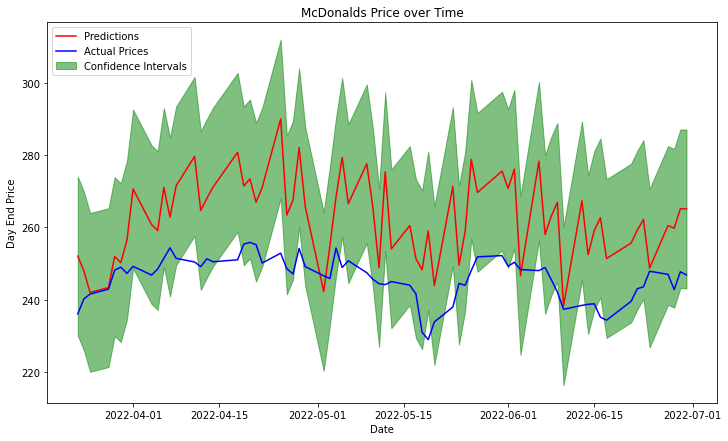

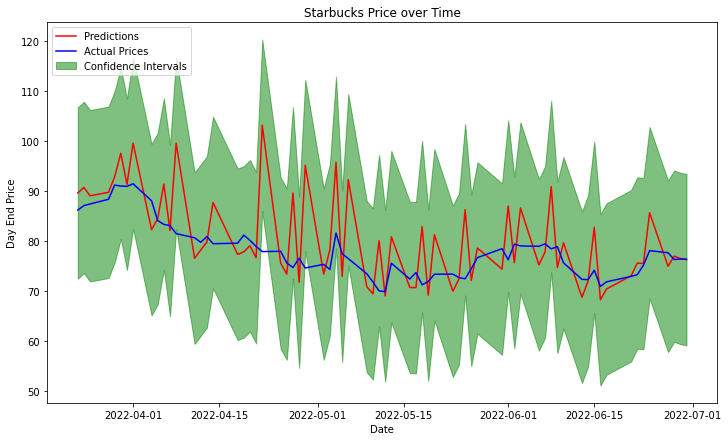

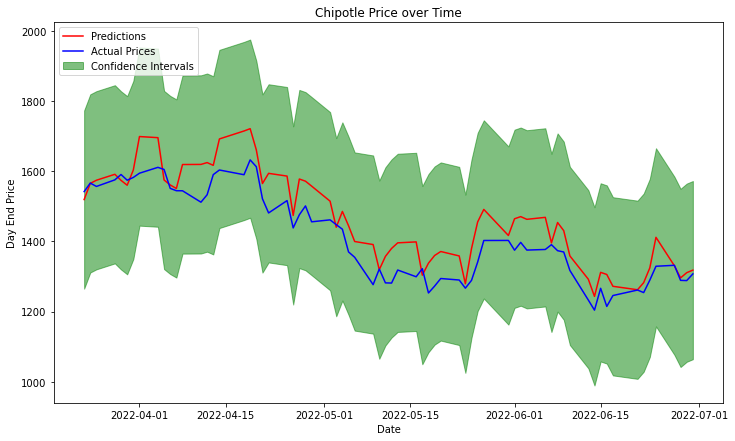

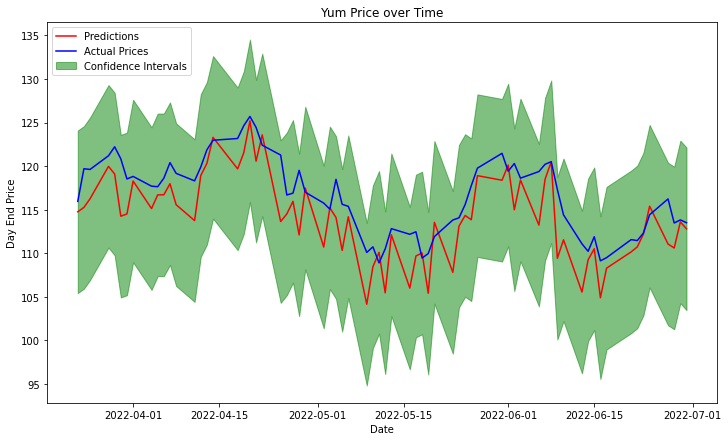

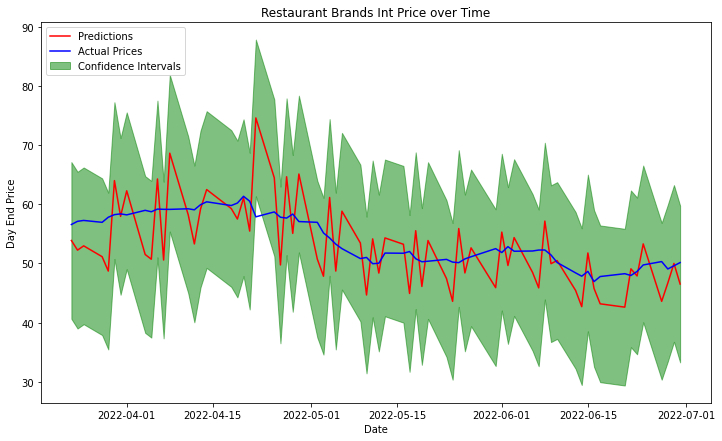

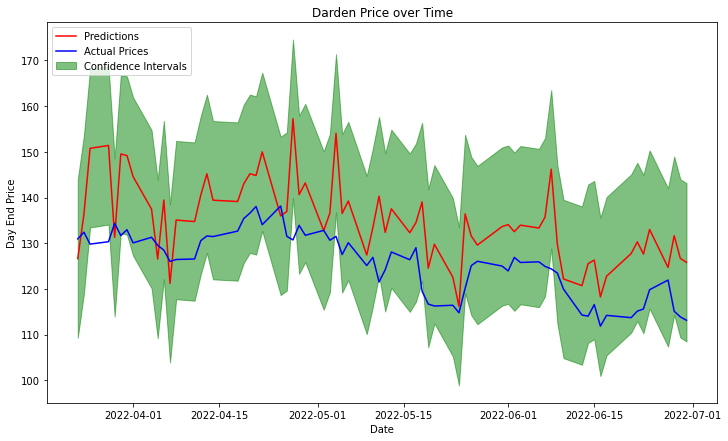

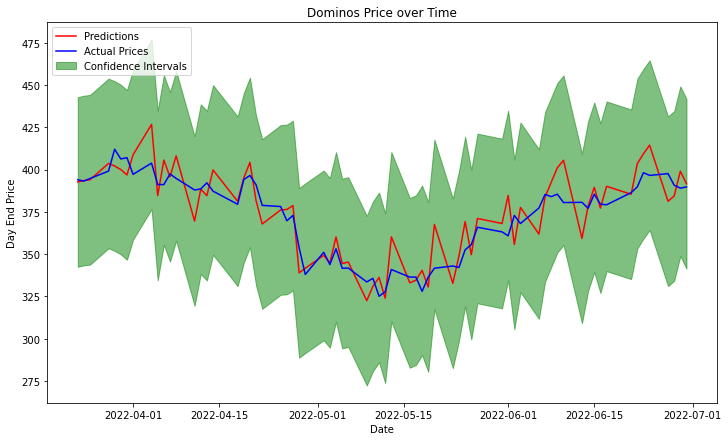

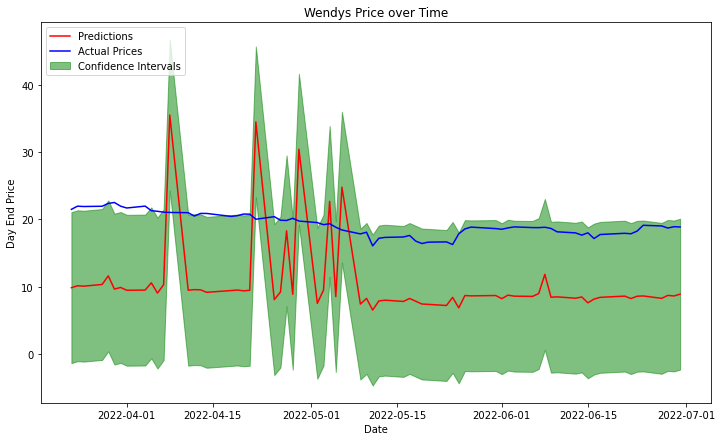

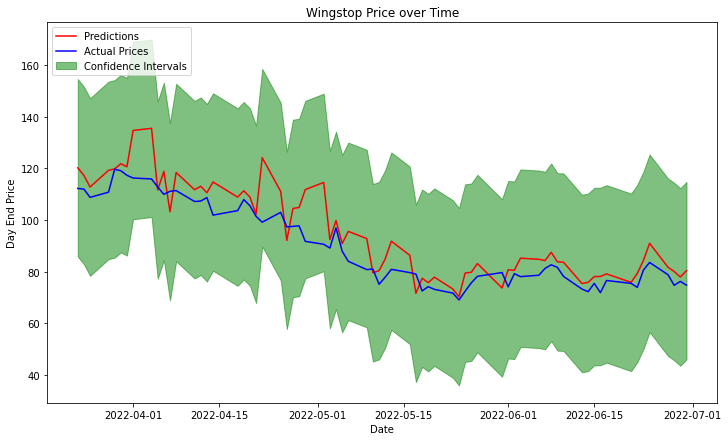

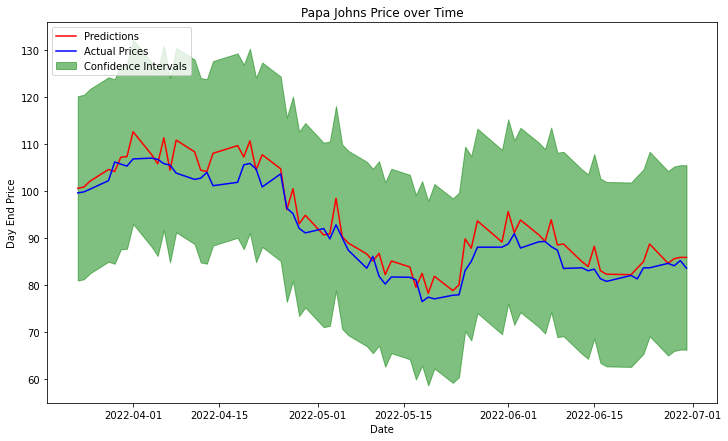

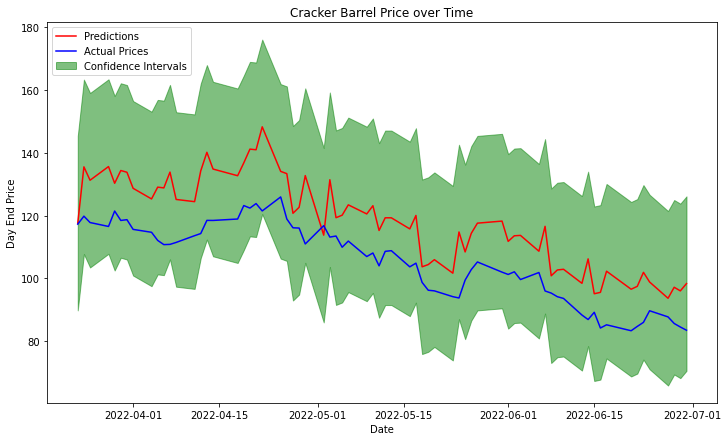

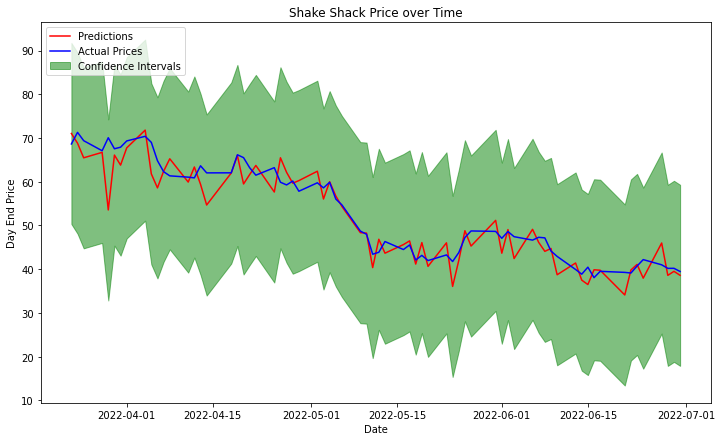

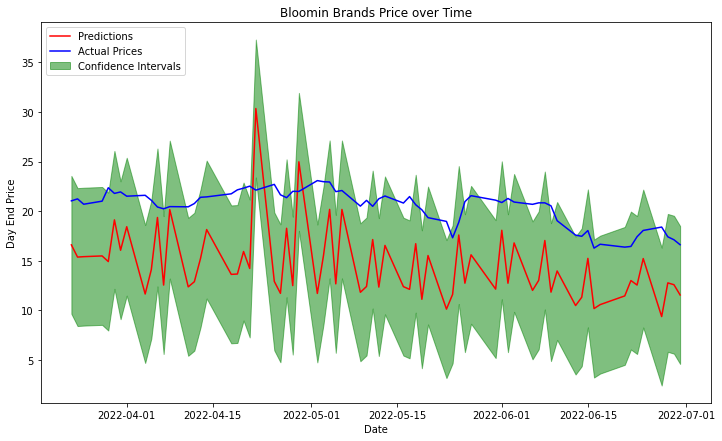

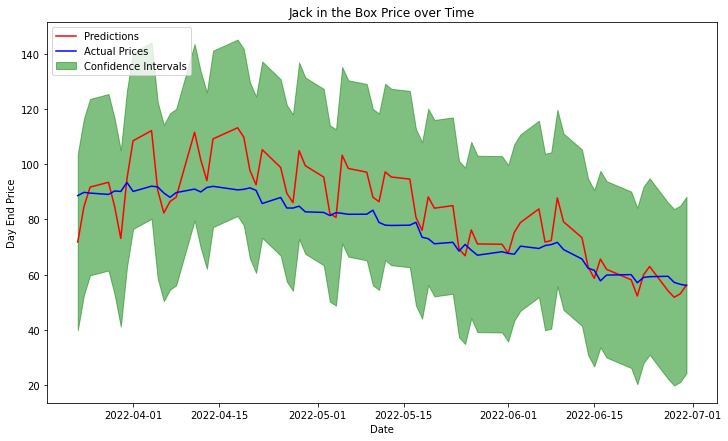

In [42]:
death_nums= merged_insample[['deaths']]
lstm_mape=dict();

for x in merged_copy.iloc[:, :14]:
    #Making a DataFrame that contains only the selected stock and the death numbers
    exogenous_df=death_nums.merge(merged_copy[x], how='left',left_on=death_nums.index, right_on=merged_copy[x].index)
    exogenous_df.set_index('key_0', inplace=True)
    #Creating training set
    training = exogenous_df.iloc[:1129]

    #"next_" would be properly called a validation set
    next_= exogenous_df.iloc[1129:1200]
    
    # Using the create_dataset function to make the DataFrame values into tensors. 
    xtrain, ytrain = create_dataset(training, training.iloc[:,1],2)#Using a lag of 2 to reflect market's responsiveness
    xnext, ynext=create_dataset(next_, next_.iloc[:,1],2)
    model_1 = Sequential()
    model_1.add(LSTM(69,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
    model_1.add(Dense(25))
    model_1.add(Dense(1))
    model_1.compile(loss="mean_squared_error", optimizer="adam")

    model_1.fit(xtrain, ytrain,
              epochs=10,
              batch_size=10,
              verbose=1,
              shuffle=False
             )

    ypred = model_1.predict(xnext)
    print(x,'equity mape', (mean_absolute_percentage_error(ypred, next_.iloc[:69,1])))
   
    ypred = asarray(ypred)
    for pred in ypred[:]:
        interval = 1.96 * ypred.std()
        lower, upper = ypred - interval, ypred + interval

    plt.figure(figsize=(12,7))
    plt.plot(merged_copy.index[1129:1198], ypred, 'r', label="Predictions")
    plt.plot(merged_copy.index[1129:1198], next_.iloc[:69,1], 'b', label="Actual")
    plt.fill_between(merged_copy.index[1129:1198], lower[:, 0], upper[:, 0], color="green", alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Day End Price")
    plt.legend(['Predictions', 'Actual Prices', 'Confidence Intervals'], loc='upper left')    

    plt.title(f'{x} Price over Time')

    mape_=mean_absolute_percentage_error(ypred, next_.iloc[:69,1])
    lstm_mape[x]=mape_*100



In [43]:
#DataFrame OF LSTM MAPEs
lstm_errors= sorted(lstm_mape.items(), key=itemgetter(1), reverse=False)
lstm_errors_per= pd.DataFrame(lstm_errors)
lstm_errors_per.rename( columns={0 :'Stock', 1:'LSTM MAPE'}, inplace=True )
lstm_errors_per

Stock   LSTM MAPE
0                 Dominos    2.333554
1                     Yum    2.419352
2              Papa Johns    2.886505
3                Chipotle    3.791981
4             Shake Shack    5.285204
5               Starbucks    5.879498
6                Wingstop    6.226826
7               McDonalds    6.291887
8                  Darden    7.108444
9   Restaurant Brands Int    8.392209
10        Jack in the Box    9.505719
11         Cracker Barrel   10.731811
12         Bloomin Brands   46.635801
13                 Wendys  111.416336

In [44]:
lstm_errors_per['LSTM MAPE'].mean()

16.350366287241325

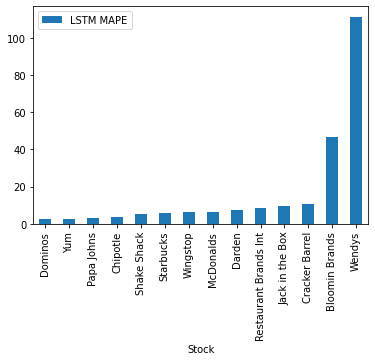

In [45]:
lstm_errors_per.plot.bar(x='Stock',y='LSTM MAPE');

That's not bad but the outliers really harm the model. Also, different iterations of this model will yield different results because LSTMs are stochastic however I did run this many time and the values are similar. 

Let's evaluate model results to see which is the best to use. I would like to use a Group bar chart so we are going to have to combine all of the error values into a DataFrame.

In [46]:
# The names of the new 'model' columns
pm='Auto.arima'
lstm='LSTM'
prop='Prophet'
# Creating the columns
lstm_errors_per = lstm_errors_per.assign(model=[lstm for x in range(14)])
pm_stock_diffs_error_per=pm_stock_diffs_error_per.assign(model=[pm for x in range(len(pm_stock_diffs_error_per.index))])
pro_stock_diffs_error_per=pro_stock_diffs_error_per.assign(model=[prop for x in range(len(pro_stock_diffs_error_per.index))])
lstm_errors_per

Stock   LSTM MAPE model
0                 Dominos    2.333554  LSTM
1                     Yum    2.419352  LSTM
2              Papa Johns    2.886505  LSTM
3                Chipotle    3.791981  LSTM
4             Shake Shack    5.285204  LSTM
5               Starbucks    5.879498  LSTM
6                Wingstop    6.226826  LSTM
7               McDonalds    6.291887  LSTM
8                  Darden    7.108444  LSTM
9   Restaurant Brands Int    8.392209  LSTM
10        Jack in the Box    9.505719  LSTM
11         Cracker Barrel   10.731811  LSTM
12         Bloomin Brands   46.635801  LSTM
13                 Wendys  111.416336  LSTM

In [47]:
#Concatenating columns
errors_combined=pd.concat([lstm_errors_per, pm_stock_diffs_error_per,pro_stock_diffs_error_per])
errors_combined.reset_index(drop=False)
errors_combined

Stock   LSTM MAPE       model  Auto Arima Percent Error  \
0                 Dominos    2.333554        LSTM                       NaN   
1                     Yum    2.419352        LSTM                       NaN   
2              Papa Johns    2.886505        LSTM                       NaN   
3                Chipotle    3.791981        LSTM                       NaN   
4             Shake Shack    5.285204        LSTM                       NaN   
5               Starbucks    5.879498        LSTM                       NaN   
6                Wingstop    6.226826        LSTM                       NaN   
7               McDonalds    6.291887        LSTM                       NaN   
8                  Darden    7.108444        LSTM                       NaN   
9   Restaurant Brands Int    8.392209        LSTM                       NaN   
10        Jack in the Box    9.505719        LSTM                       NaN   
11         Cracker Barrel   10.731811        LSTM                       NaN   
12         Bloomin Brands   46.635801        LSTM                       NaN   
13                 Wendys  111.416336        LSTM                       NaN   
0                     Yum         NaN  Auto.arima                  3.369135   
1               McDonalds         NaN  Auto.arima                  3.550413   
2                  Darden         NaN  Auto.arima                  6.033674   
3                 Dominos         NaN  Auto.arima                  7.303606   
4          Bloomin Brands         NaN  Auto.arima                  7.822786   
5   Restaurant Brands Int         NaN  Auto.arima                  9.558524   
6              Papa Johns         NaN  Auto.arima                 13.353235   
7               Starbucks         NaN  Auto.arima                 13.491130   
8                Chipotle         NaN  Auto.arima                 14.667805   
9                  Wendys         NaN  Auto.arima                 14.873851   
10         Cracker Barrel         NaN  Auto.arima                 16.258556   
11        Jack in the Box         NaN  Auto.arima                 18.909092   
12            Shake Shack         NaN  Auto.arima                 34.589714   
13               Wingstop         NaN  Auto.arima                 35.081751   
0               McDonalds         NaN     Prophet                       NaN   
1   Restaurant Brands Int         NaN     Prophet                       NaN   
2                Chipotle         NaN     Prophet                       NaN   
3                 Dominos         NaN     Prophet                       NaN   
4         Jack in the Box         NaN     Prophet                       NaN   
5                     Yum         NaN     Prophet                       NaN   
6                  Darden         NaN     Prophet                       NaN   
7               Starbucks         NaN     Prophet                       NaN   
8          Bloomin Brands         NaN     Prophet                       NaN   
9                  Wendys         NaN     Prophet                       NaN   
10             Papa Johns         NaN     Prophet                       NaN   
11         Cracker Barrel         NaN     Prophet                       NaN   
12            Shake Shack         NaN     Prophet                       NaN   
13               Wingstop         NaN     Prophet                       NaN   

    Prophet Percent Error  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6                     NaN  
7                     NaN  
8                     NaN  
9                     NaN  
10                    NaN  
11                    NaN  
12                    NaN  
13                    NaN  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
5                     NaN  
6                     NaN  
7     

In [48]:
# Filling the NaNs and adding the error columns together.
errors_combined.fillna(0, inplace=True)
errors_combined['errors']=errors_combined['LSTM MAPE']+ errors_combined['Auto Arima Percent Error']+errors_combined['Prophet Percent Error']
errors_combined

Stock   LSTM MAPE       model  Auto Arima Percent Error  \
0                 Dominos    2.333554        LSTM                  0.000000   
1                     Yum    2.419352        LSTM                  0.000000   
2              Papa Johns    2.886505        LSTM                  0.000000   
3                Chipotle    3.791981        LSTM                  0.000000   
4             Shake Shack    5.285204        LSTM                  0.000000   
5               Starbucks    5.879498        LSTM                  0.000000   
6                Wingstop    6.226826        LSTM                  0.000000   
7               McDonalds    6.291887        LSTM                  0.000000   
8                  Darden    7.108444        LSTM                  0.000000   
9   Restaurant Brands Int    8.392209        LSTM                  0.000000   
10        Jack in the Box    9.505719        LSTM                  0.000000   
11         Cracker Barrel   10.731811        LSTM                  0.000000   
12         Bloomin Brands   46.635801        LSTM                  0.000000   
13                 Wendys  111.416336        LSTM                  0.000000   
0                     Yum    0.000000  Auto.arima                  3.369135   
1               McDonalds    0.000000  Auto.arima                  3.550413   
2                  Darden    0.000000  Auto.arima                  6.033674   
3                 Dominos    0.000000  Auto.arima                  7.303606   
4          Bloomin Brands    0.000000  Auto.arima                  7.822786   
5   Restaurant Brands Int    0.000000  Auto.arima                  9.558524   
6              Papa Johns    0.000000  Auto.arima                 13.353235   
7               Starbucks    0.000000  Auto.arima                 13.491130   
8                Chipotle    0.000000  Auto.arima                 14.667805   
9                  Wendys    0.000000  Auto.arima                 14.873851   
10         Cracker Barrel    0.000000  Auto.arima                 16.258556   
11        Jack in the Box    0.000000  Auto.arima                 18.909092   
12            Shake Shack    0.000000  Auto.arima                 34.589714   
13               Wingstop    0.000000  Auto.arima                 35.081751   
0               McDonalds    0.000000     Prophet                  0.000000   
1   Restaurant Brands Int    0.000000     Prophet                  0.000000   
2                Chipotle    0.000000     Prophet                  0.000000   
3                 Dominos    0.000000     Prophet                  0.000000   
4         Jack in the Box    0.000000     Prophet                  0.000000   
5                     Yum    0.000000     Prophet                  0.000000   
6                  Darden    0.000000     Prophet                  0.000000   
7               Starbucks    0.000000     Prophet                  0.000000   
8          Bloomin Brands    0.000000     Prophet                  0.000000   
9                  Wendys    0.000000     Prophet                  0.000000   
10             Papa Johns    0.000000     Prophet                  0.000000   
11         Cracker Barrel    0.000000     Prophet                  0.000000   
12            Shake Shack    0.000000     Prophet                  0.000000   
13               Wingstop    0.000000     Prophet                  0.000000   

    Prophet Percent Error      errors  
0                0.000000    2.333554  
1                0.000000    2.419352  
2                0.000000    2.886505  
3                0.000000    3.791981  
4                0.000000    5.285204  
5                0.000000    5.879498  
6                0.000000    6.226826  
7                0.000000    6.291887  
8                0.000000    7.108444  
9                0.000000    8.392209  
10               0.000000    9.505719  
11               0.000000   10.731811  
12               0.000000   46.635801  
13               0.000000  111.416336  
0                0.000

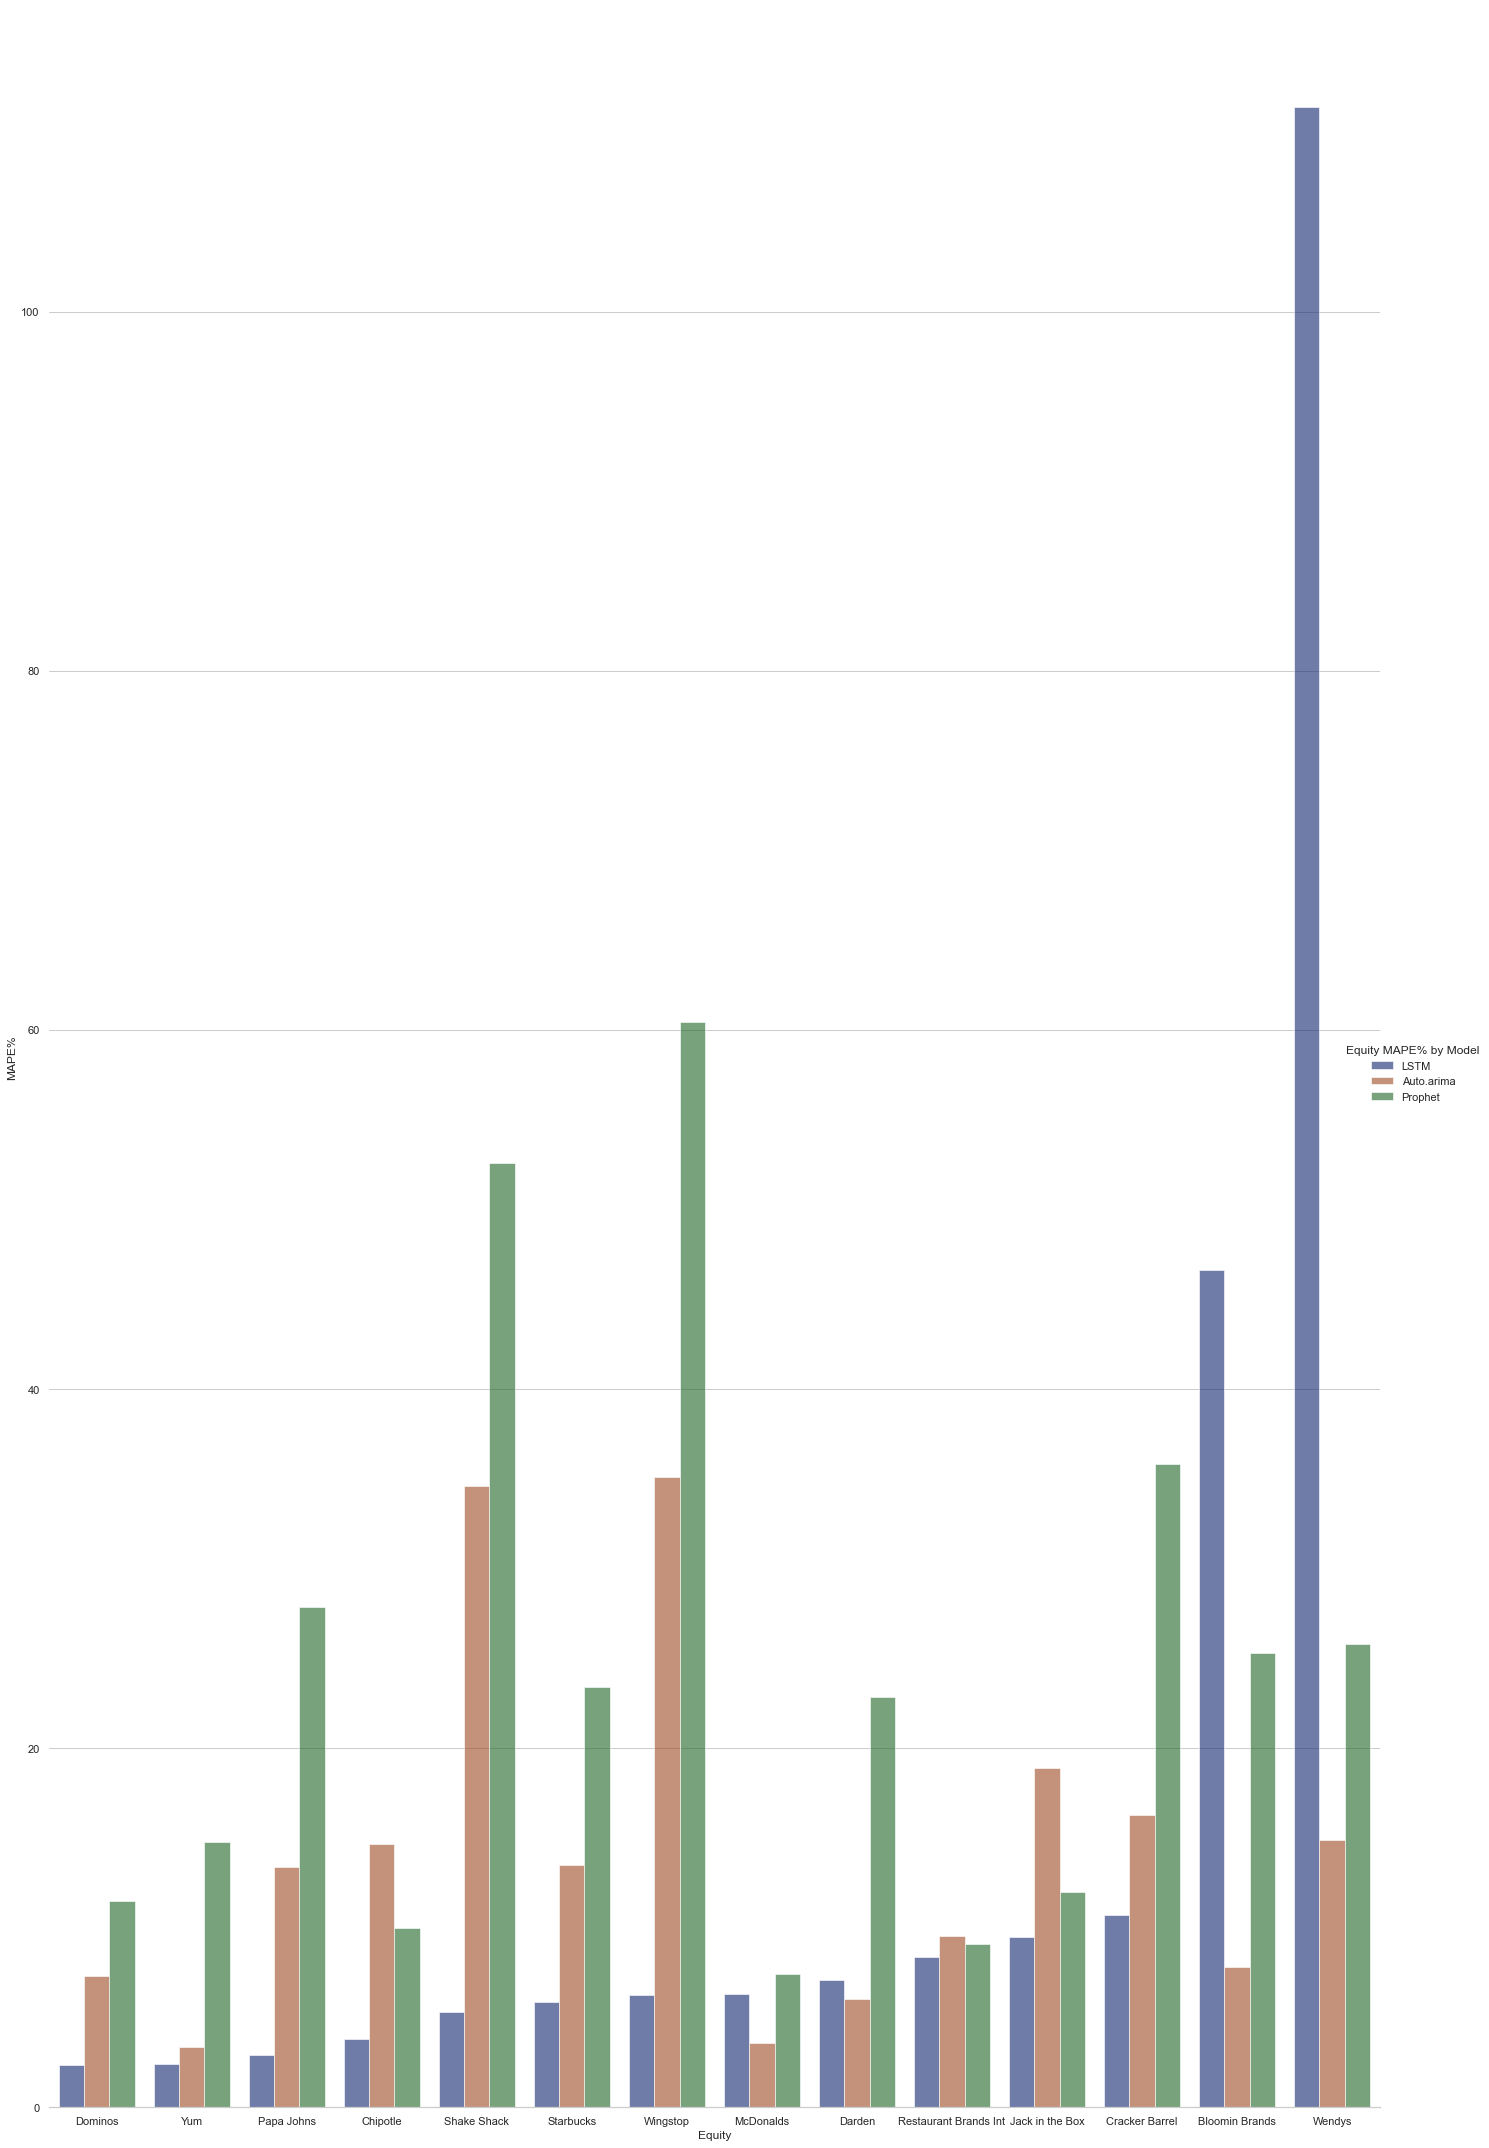

In [49]:
sns.set_theme(style="whitegrid")
#plt.figure(figsize=(30,20))

g = sns.catplot(
    data=errors_combined, kind="bar",
    x="Stock", y="errors", hue="model",
     palette="dark", alpha=.6, height=30, aspect=.65
)
g.despine(left=True)
g.set_axis_labels("Equity", "MAPE%")
g.legend.set_title("Equity MAPE% by Model");


The Auto.Arima model was surprisingly good. However, I will still go with the LSTM model because its performance was better but was harmed by a few serious outliers. I will have to either disregard predictions on those equities or be very cautious when drawing conclusions from them.

Ok, Now, I will make out of sample predictions on the LSTM since it performed the best except for a few outliers.

In [50]:
#Opening the death predictions
death_preds = pd.read_excel ("7day_delay_withmy_preds.xlsx")
#Merging with restaurants
full_dataset=restaurants.merge(death_preds, how='left',left_on=restaurants.index, right_on=death_preds['ds'])
#Renaming columns
full_dataset.rename(columns={"y": "deaths", "key_0":"Dates"}, inplace=True)
#Creating a copy before I set index
full_dataset_copy=full_dataset.copy(deep=True)
#Dropping columns
full_dataset.drop('ds', axis=1, inplace=True)
full_dataset.drop('deaths', axis=1, inplace=True)

full_dataset.set_index('Dates', inplace=True)
full_dataset

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  
Dates                        
2017-09-27       100.199997  
2017-09-28       101.040001  
2017-09-29       101.919998  
2017-10-02       100.589996  
2017-10-03        99.339996  
...                     ...  
2022-12-26              NaN  
2022-12-27              NaN  
2022-12-28              NaN  
2022-12-29              NaN  
2022-12-30              NaN  

[1335 rows x 14 columns]

I need to immediately eliminate any null from the 'deaths' column:

In [51]:
full_dataset_copy.iloc[1267:]

Dates  McDonalds  Starbucks  Chipotle  Yum  Restaurant Brands Int  \
1267 2022-10-10        NaN        NaN       NaN  NaN                    NaN   
1268 2022-10-11        NaN        NaN       NaN  NaN                    NaN   
1269 2022-10-12        NaN        NaN       NaN  NaN                    NaN   
1270 2022-10-13        NaN        NaN       NaN  NaN                    NaN   
1271 2022-10-14        NaN        NaN       NaN  NaN                    NaN   
...         ...        ...        ...       ...  ...                    ...   
1330 2022-12-26        NaN        NaN       NaN  NaN                    NaN   
1331 2022-12-27        NaN        NaN       NaN  NaN                    NaN   
1332 2022-12-28        NaN        NaN       NaN  NaN                    NaN   
1333 2022-12-29        NaN        NaN       NaN  NaN                    NaN   
1334 2022-12-30        NaN        NaN       NaN  NaN                    NaN   

      Darden  Dominos  Wendys  Wingstop  Papa Johns  Cracker Barrel  \
1267     NaN      NaN     NaN       NaN         NaN             NaN   
1268     NaN      NaN     NaN       NaN         NaN             NaN   
1269     NaN      NaN     NaN       NaN         NaN             NaN   
1270     NaN      NaN     NaN       NaN         NaN             NaN   
1271     NaN      NaN     NaN       NaN         NaN             NaN   
...      ...      ...     ...       ...         ...             ...   
1330     NaN      NaN     NaN       NaN         NaN             NaN   
1331     NaN      NaN     NaN       NaN         NaN             NaN   
1332     NaN      NaN     NaN       NaN         NaN             NaN   
1333     NaN      NaN     NaN       NaN         NaN             NaN   
1334     NaN      NaN     NaN       NaN         NaN             NaN   

      Shake Shack  Bloomin Brands  Jack in the Box         ds       deaths  
1267          NaN             NaN              NaN 2022-10-10   652.000000  
1268          NaN             NaN              NaN 2022-10-11   324.000000  
1269          NaN             NaN              NaN 2022-10-12  1823.521034  
1270          NaN             NaN              NaN 2022-10-13  1645.752965  
1271          NaN             NaN              NaN 2022-10-14  1693.663130  
...           ...             ...              ...        ...          ...  
1330          NaN             NaN              NaN 2022-12-26  2188.014113  
1331          NaN             NaN              NaN 2022-12-27  2910.569217  
1332          NaN             NaN              NaN 2022-12-28  2910.907724  
1333          NaN             NaN              NaN 2022-12-29  2911.805639  
1334          NaN             NaN              NaN 2022-12-30  2953.894081  

[68 rows x 17 columns]

In [52]:
#Eliminating nulls
full_dataset_copy['deaths'].fillna(0, axis=0, inplace=True)

In [53]:
#Setting index
full_dataset_copy.set_index('Dates', inplace=True)


In [54]:
full_dataset

McDonalds  Starbucks    Chipotle        Yum  \
Dates                                                      
2017-09-27  154.050003  54.990002  313.850006  73.099998   
2017-09-28  157.490005  54.500000  316.529999  73.500000   
2017-09-29  156.679993  53.709999  307.829987  73.610001   
2017-10-02  156.960007  53.810001  301.809998  73.750000   
2017-10-03  156.860001  53.990002  302.989990  73.919998   
...                ...        ...         ...        ...   
2022-12-26         NaN        NaN         NaN        NaN   
2022-12-27         NaN        NaN         NaN        NaN   
2022-12-28         NaN        NaN         NaN        NaN   
2022-12-29         NaN        NaN         NaN        NaN   
2022-12-30         NaN        NaN         NaN        NaN   

            Restaurant Brands Int     Darden     Dominos  Wendys   Wingstop  \
Dates                                                                         
2017-09-27              63.869999  79.150002  196.839996   15.58  33.540001   
2017-09-28              63.880001  78.959999  197.039993   15.57  33.340000   
2017-09-29              63.880001  78.779999  198.550003   15.53  33.250000   
2017-10-02              64.269997  79.169998  199.990005   15.29  33.610001   
2017-10-03              64.040001  80.110001  202.809998   15.47  33.480000   
...                           ...        ...         ...     ...        ...   
2022-12-26                    NaN        NaN         NaN     NaN        NaN   
2022-12-27                    NaN        NaN         NaN     NaN        NaN   
2022-12-28                    NaN        NaN         NaN     NaN        NaN   
2022-12-29                    NaN        NaN         NaN     NaN        NaN   
2022-12-30                    NaN        NaN         NaN     NaN        NaN   

            Papa Johns  Cracker Barrel  Shake Shack  Bloomin Brands  \
Dates                                                                 
2017-09-27   74.699997      149.550003    32.580002       17.420000   
2017-09-28   73.660004      150.399994    32.950001       17.510000   
2017-09-29   73.070000      151.619995    33.230000       17.600000   
2017-10-02   72.559998      153.899994    33.389999       17.639999   
2017-10-03   70.610001      153.210007    33.139999       17.170000   
...                ...             ...          ...             ...   
2022-12-26         NaN             NaN          NaN             NaN   
2022-12-27         NaN             NaN          NaN             NaN   
2022-12-28         NaN             NaN          NaN             NaN   
2022-12-29         NaN             NaN          NaN             NaN   
2022-12-30         NaN             NaN          NaN             NaN   

            Jack in the Box  
Dates                        
2017-09-27       100.199997  
2017-09-28       101.040001  
2017-09-29       101.919998  
2017-10-02       100.589996  
2017-10-03        99.339996  
...                     ...  
2022-12-26              NaN  
2022-12-27              NaN  
2022-12-28              NaN  
2022-12-29              NaN  
2022-12-30              NaN  

[1335 rows x 14 columns]

I am going to make out of sample predictions using the same strategy that I used to make in sample predictions. However, this time I will swap the NaNs and 0s in the price column for the previous mean.

Epoch 1/10
113/113 [==============================] - 3s 4ms/step - loss: 6975.7710
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 1224.9353
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 3389.9956
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 1411.0624
Epoch 5/10
113/113 [==============================] - 1s 4ms/step - loss: 2136.7180
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 1612.5552
Epoch 7/10
113/113 [==============================] - 0s 4ms/step - loss: 175.8694
Epoch 8/10
113/113 [==============================] - 0s 4ms/step - loss: 77.5174
Epoch 9/10
113/113 [==============================] - 1s 4ms/step - loss: 77.4105
Epoch 10/10
3/3 [==============================] - 0s 8ms/step
Epoch 1/10
113/113 [==============================] - 3s 4ms/step - loss: 3354.1484
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 4661.4268
Epoch 3/10
113/113

113/113 [==============================] - 0s 4ms/step - loss: 2119.9177
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 738.6117
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 234.8036
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 241.5986
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 152.8317
Epoch 8/10
113/113 [==============================] - 1s 6ms/step - loss: 372.7014
Epoch 9/10
113/113 [==============================] - 1s 5ms/step - loss: 854.9155
Epoch 10/10
3/3 [==============================] - 1s 16ms/step
Epoch 1/10
113/113 [==============================] - 3s 5ms/step - loss: 6729.3506
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 2184.2307
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 464.8753
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 651.1351
Epoch 5/10
113/113 [===========

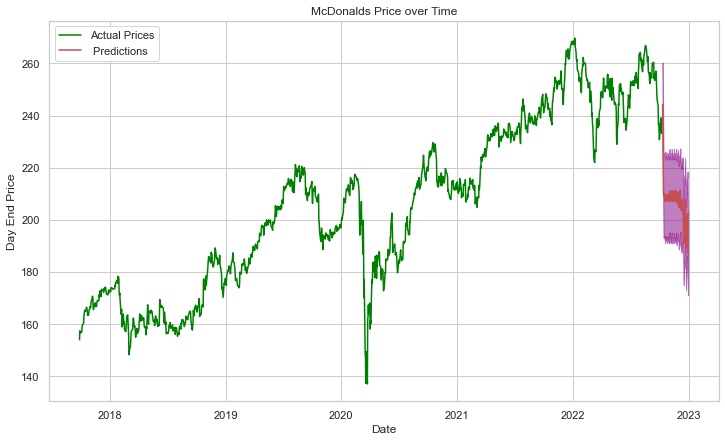

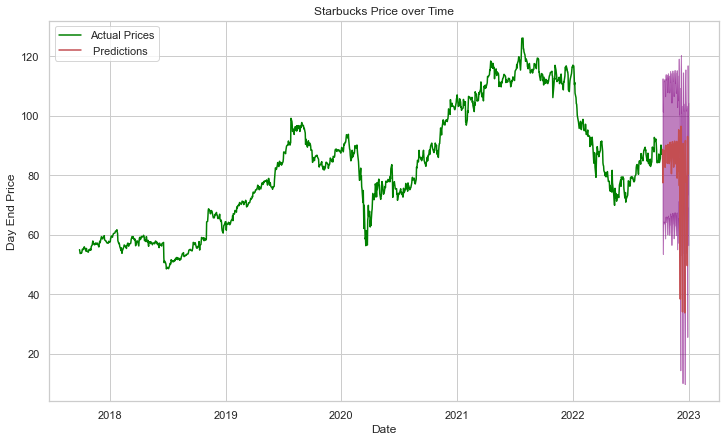

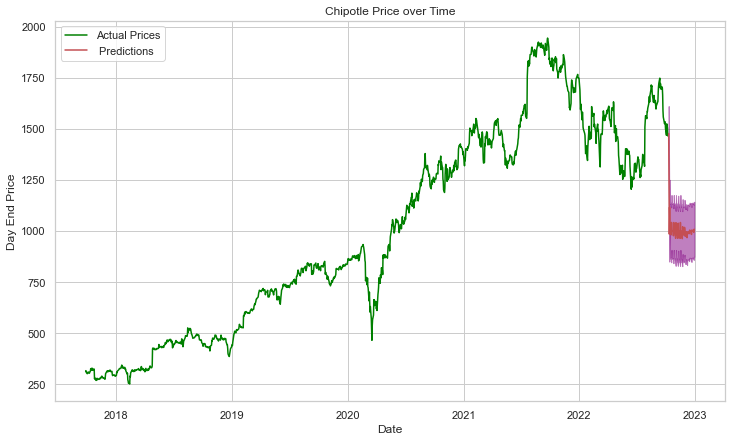

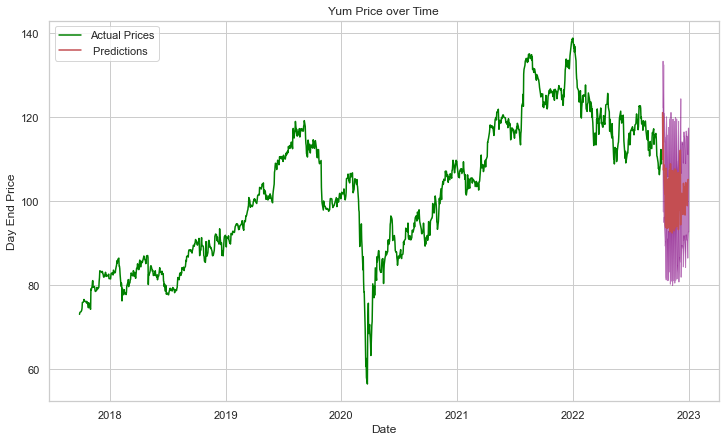

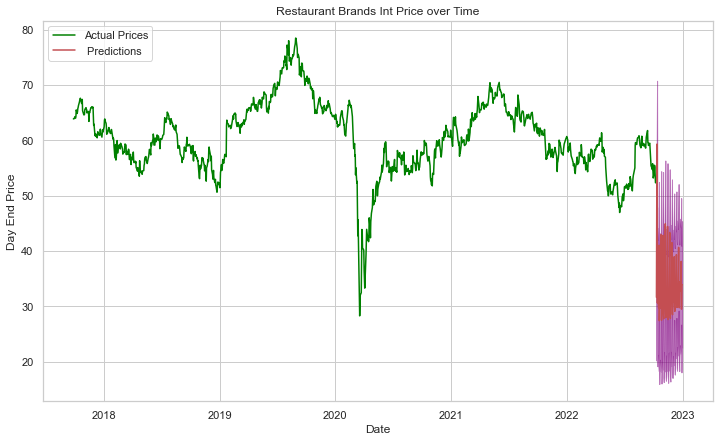

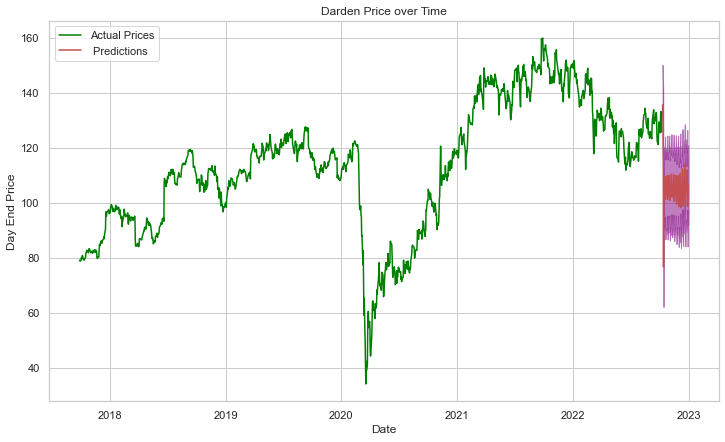

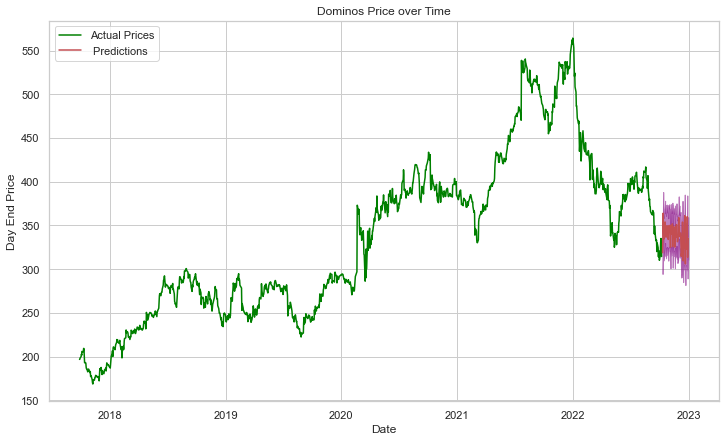

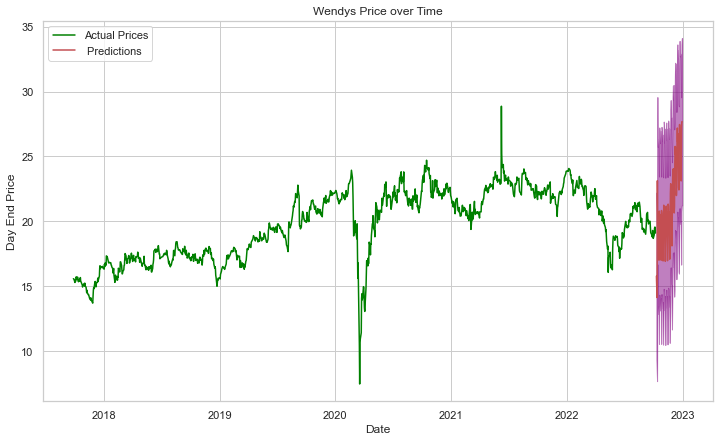

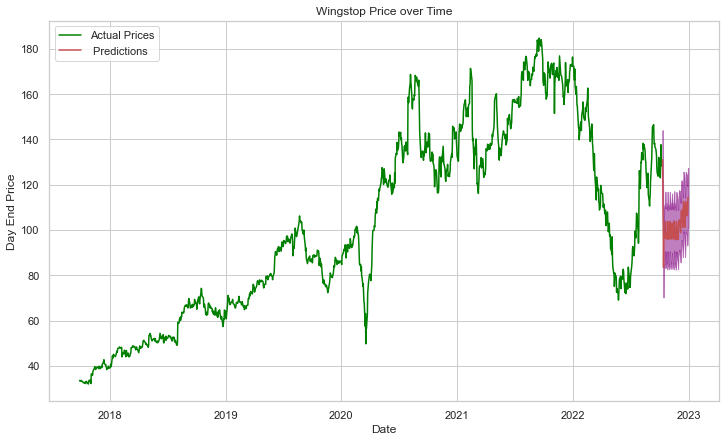

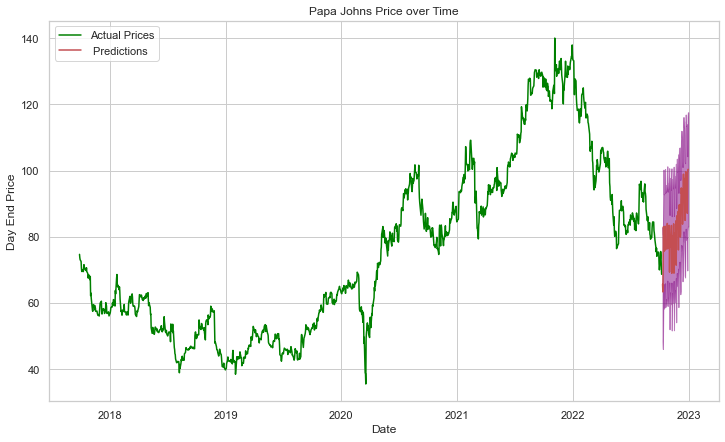

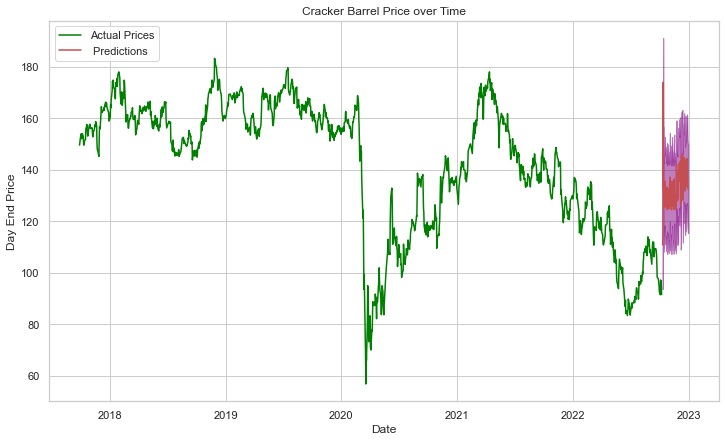

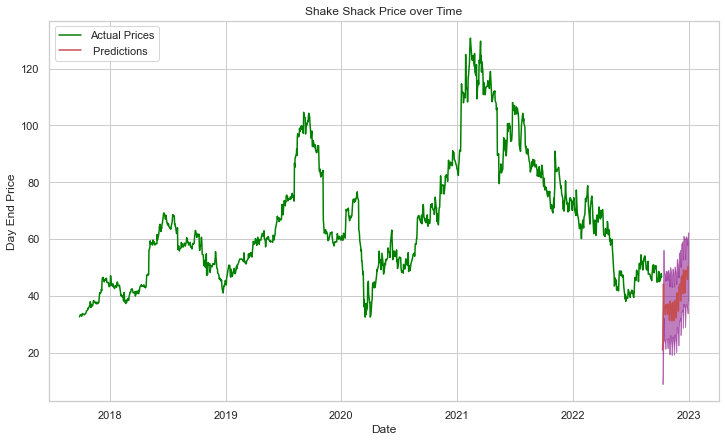

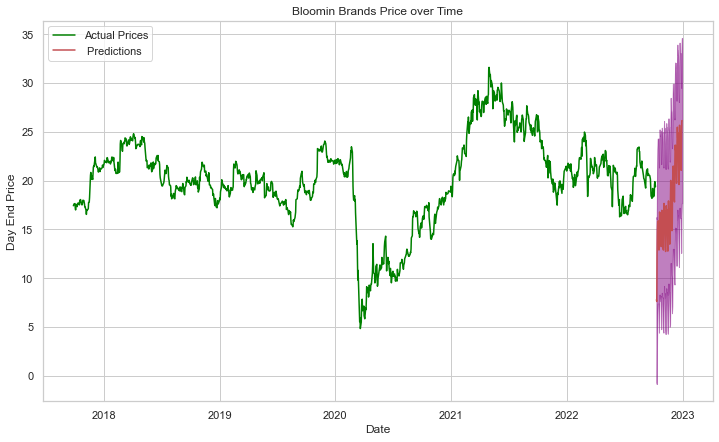

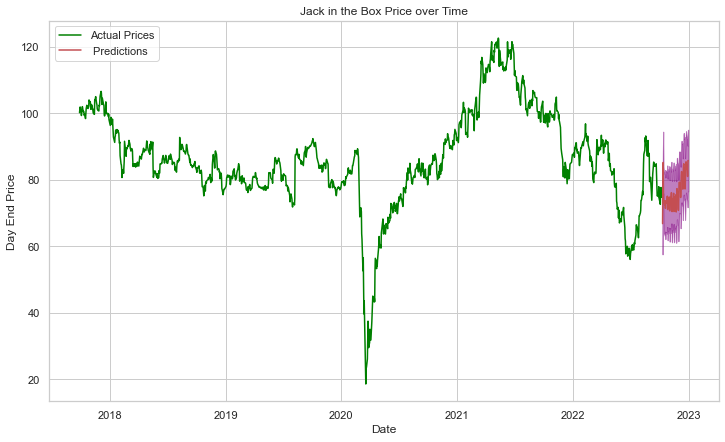

In [55]:

death_future= full_dataset_copy[['deaths']]
roi=dict();
for x in full_dataset.iloc[:]:
    #Merging the death numbers and price numbers
    exogenous_df_preds=death_future.merge(full_dataset[x], how='left',left_on=death_future.index, right_on=full_dataset[x].index)
    #Setting index
    exogenous_df_preds.set_index('key_0', inplace=True)
    #Filling  the empty price dates with the mean of previous values
    exogenous_df_preds.fillna(full_dataset[x].mean(), axis=1, inplace=True)



    training_1 = exogenous_df_preds.iloc[:1127]
    # future_values will be the name of the future data that is disguised as actual data
    future_values= exogenous_df_preds.iloc[1265:]

    xtrain, ytrain = create_dataset(training_1, training_1.iloc[:,1],2)
    xfuture, yfuture=create_dataset(future_values, future_values.iloc[:,1],2)
    model_1 = Sequential()
    model_1.add(LSTM(70,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2] )))
    model_1.add(Dense(25))
    model_1.add(Dense(1))
    model_1.compile(loss="mean_squared_error", optimizer="adam")

    model_1.fit(xtrain, ytrain,
              epochs=10,
              batch_size=10,
              verbose=1,
              shuffle=False
             )

    ypred_1 = model_1.predict(xfuture)
    ypred_1_array = asarray(ypred_1)
    
    #print(preds_list)
    for preds in ypred_1_array[:]:
        interval = 1.96 * ypred_1_array.std()
        lower, upper = ypred_1_array - interval, ypred_1_array + interval

    plt.figure(figsize=(12,7))
    plt.plot(merged_copy.index[:1267], full_dataset[x][:1267], 'green', label='Actual Prices')
    plt.plot(merged_copy.index[1267:], ypred_1_array, 'r', label="Predictions")
    
    plt.fill_between(merged_copy.index[1267:], lower[:, 0], upper[:, 0], color="purple", alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Day End Price")
    plt.legend([ 'Actual Prices', ' Predictions'], loc='upper left')    

    plt.title(f'{x} Price over Time')
    final_observed=full_dataset[x][1266]
    
    diff=ypred_1[65,0]-full_dataset[x][1266]
    rois=diff/final_observed
    roi[x]=rois*100
    

# Results

In [56]:
from operator import itemgetter, attrgetter
roi_dictionary= sorted(roi.items(), key=itemgetter(1), reverse=False)
LSTM_ROI= pd.DataFrame(roi_dictionary)
LSTM_ROI.rename( columns={0 :'Stock', 1:'Projected ROI'}, inplace=True )
LSTM_ROI

Stock  Projected ROI
0   Restaurant Brands Int     -43.659940
1                Chipotle     -32.229933
2                  Darden     -21.456285
3                Wingstop     -15.628487
4               McDonalds     -13.185696
5                     Yum      -5.294168
6             Shake Shack      -1.780614
7                 Dominos      -0.280883
8               Starbucks       6.879673
9         Jack in the Box       8.363378
10         Bloomin Brands      28.332012
11                 Wendys      42.488220
12             Papa Johns      44.240424
13         Cracker Barrel      47.333244

Here are the results:

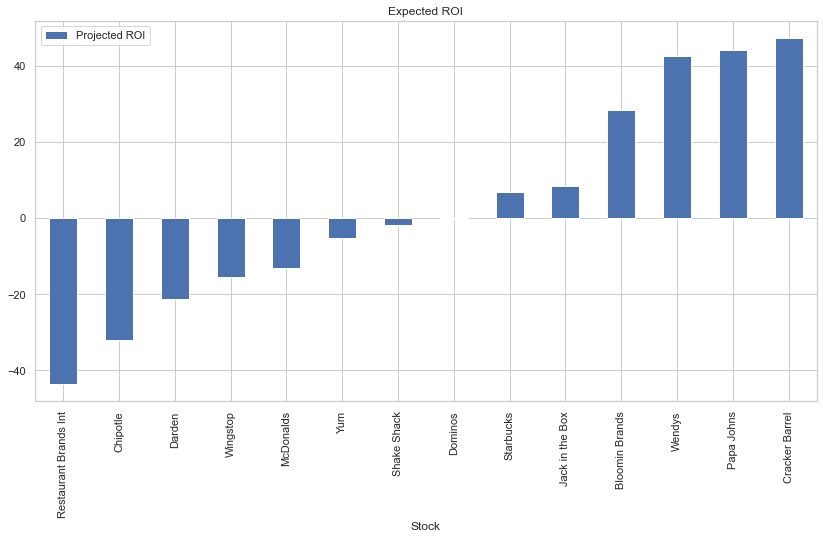

In [57]:
LSTM_ROI.plot.bar(x='Stock',y='Projected ROI', figsize=(14,7), title='Expected ROI');

The results look good but there are a few caveats namely that the training errors for some of the equities were so high that they cannot be relied upon. Therefore, let's eliminate the stocks with high MAPEs. Of course, LSTM models are stochastic so the results will vary. However, I ran this model multiple times and while the results change, they don't drastically change the results.

### TOP 3 PERFORMERS

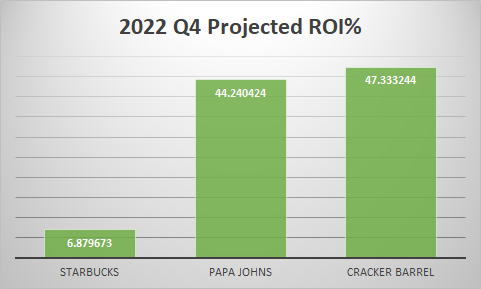

### BOTTOM 3 PERFORMERS
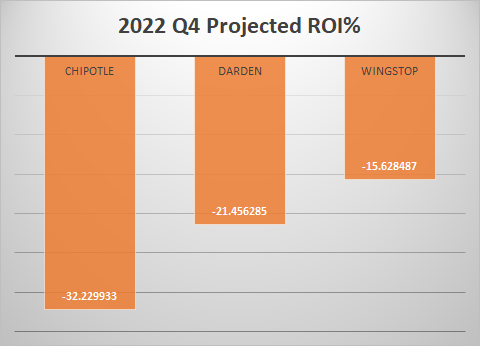

# CONCLUSION

**The top performers were Cracker Barrel, Papa Johns, and Dominos while the poorest performers were Chipotle, Wingstop, and McDonalds**. The model’s results will help investors hoping for insight into the restaurant industry’s Q4 performance. Especially important in this model is its incorporation of COVID-19 death numbers. Thankfully, my prediction for COVID deaths are probably too high but there are no available datasets available that make better predictions at the same 2.5 month interval. In fact, most predictions only predict for 4 weeks and not on individual days. 


This notebook is a very fruitful start for modeling stock prices. However, some of its assumption could justifiably be questioned. The temporal link between COVID deaths and stock prices is real but the exact amount of time is not entirely clear. In fact, there is good evidence that it is actually much longer than I assume here. Moreover, there is good evidence that in-person dining actually effects COVID rates so these 2 variables could very well be in a feedback loop:

https://journals.lww.com/epidem/fulltext/2022/03000/the_impact_of_keeping_indoor_dining_closed_on.7.aspx

More exogenous variables like real estate prices, volume, commodities prices, inflation rate and interest rates would certainly enhance this dataset and its analysis.

Overall, the model provides a great beginning for modeling stock prices.
